# Movie Investigations for Microsoft 

**Author**: Aysu Erdemir

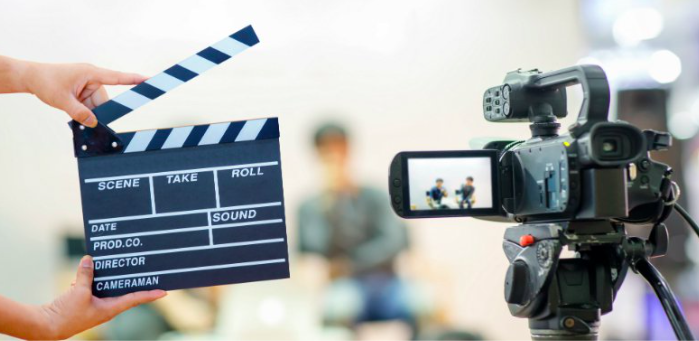

In [1]:
from IPython.display import Image
Image(filename='images/image.png')

## Overview

This project analyzes movie data to provide insights and recommendations about the kind of movies Microsoft should focus on for their new movie studio. 

## Business Problem

Microsoft has decided to create a new movie studio, but they need information about what kind of movies are doing best financially. I will be performing exploratory analyses on data from past movies to help Microsoft decide what kind of movies to create. 

***
The process unfolds in this manner:
* Defining reliable measure(s) for assessing the success and profitability of a movie using `gross`, `budget` or audience `ratings`. 
* Looking into various movie characteristics such as `genre`, `director`, `release_month` and `runtime` for highly profitable movies in the past.
* Making suggestions about the kind of movies to be made based on the findings.
***

## Data Understanding

***
I will be using:
1. [IMDb dataset](https://www.imdb.com/) involves 4 tables and 140416 Distinct Movies:
    - `movie_basics` which involves  title, year, runtime, and genre information for each movie.
    - `movie_ratings` which involves average rating.
    - `directors` which involves director ID for each movie.
    - `persons` which allows us to link director IDs to their names. 

The variables representing movie carahacteristics will be mainly derived from this database. 

2.[The Numbers dataset](https://www.the-numbers.com/) which involves movie `budget` as well as `gross` information and 5698 distinct movies.

The measures for assesing profitability will be mainly derived from this datasheet. 
***   


In [2]:
# Import standard packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import seaborn as sns
%matplotlib inline

Load the IMDB database file (im.db) using SQLite and explore the tables:

In [3]:
# Read the tables using sqlite
import sqlite3 
conn= sqlite3.connect('zippedData/im.db')

In [4]:
# Read the table movie_basics
movie_basics = pd.read_sql("""
SELECT *
FROM movie_basics;
""", conn)
movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [5]:
movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [6]:
movie_basics.describe()

,start_year,runtime_minutes
count,146144.000000,114405.000000
mean,2014.621798,86.187247
std,2.733583,166.360590
min,2010.000000,1.000000
25%,2012.000000,70.000000
50%,2015.000000,87.000000
75%,2017.000000,99.000000
max,2115.000000,51420.000000


In [7]:
print(movie_basics[movie_basics['runtime_minutes'] == 51420])
print(movie_basics[movie_basics['start_year'] == 2115])
# Indeed there is a film with a runtime of 857 hours which is the longest film ever made.
# It seems like IMDB is also showing movies that are currently under development.

         movie_id primary_title original_title  start_year  runtime_minutes  \
132389  tt8273150     Logistics      Logistics        2012          51420.0   

             genres  
132389  Documentary  
        movie_id primary_title original_title  start_year  runtime_minutes  \
89506  tt5174640     100 Years      100 Years        2115              NaN   

      genres  
89506  Drama  


In [8]:
# Are there any duplicated entries?
movie_basics['movie_id'].duplicated().sum()

0

**Issues to consider about movie_basics:**
- `movie_id` is the primary key, there are 146.144 movies. 
- Use `primary_title` instead of `original_title` since it is in English.
- Since some movies have multiple `genres`, split the text and assign them to seperate rows.

In [9]:
movie_ratings = pd.read_sql("""
SELECT *
FROM movie_ratings;
""", conn)

movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [10]:
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie_id       73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


In [11]:
# suppress scientific notation output while using .describe()
movie_ratings.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,averagerating,numvotes
count,73856.00,73856.00
mean,6.33,3523.66
std,1.47,30294.02
min,1.00,5.00
25%,5.50,14.00
50%,6.50,49.00
75%,7.40,282.00
max,10.00,1841066.00


In [12]:
movie_ratings['movie_id'].duplicated().sum()

0

In [13]:
movie_ratings[movie_ratings['numvotes']==1841066]

,movie_id,averagerating,numvotes
63498,tt1375666,8.8,1841066


In [14]:
# Inception indeed has been voted for 1841066 times. 
movie_basics[movie_basics['movie_id']=='tt1375666']

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
7066,tt1375666,Inception,Inception,2010,148.0,"Action,Adventure,Sci-Fi"


**Issues to consider about movie_ratings:**
- `movie_id` is the primary key, there are 73856 movies, about half the size of movies in movie_basics. 
- We can use `averagerating` as an indication of how much people like each movie but you might disregard those with low counts. 

In [15]:
directors = pd.read_sql("""
SELECT *
FROM directors;
""", conn)

directors.head()

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502


In [16]:
directors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291174 entries, 0 to 291173
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   movie_id   291174 non-null  object
 1   person_id  291174 non-null  object
dtypes: object(2)
memory usage: 4.4+ MB


In [17]:
directors.nunique()

movie_id     140417
person_id    109253
dtype: int64

In [18]:
print(directors.duplicated().sum())
print(directors['movie_id'].duplicated().sum())
print(directors['person_id'].duplicated().sum())
# There are 127.639 duplicated rows, 150.757 duplicated movies and 181.921 duplicated persons.

127639
150757
181921


In [19]:
directors[directors.duplicated()].sort_values(by= 'movie_id').head(10)

,movie_id,person_id
222428,tt0063540,nm0712540
222429,tt0063540,nm0712540
222430,tt0063540,nm0712540
68345,tt0069049,nm0000080
252268,tt0100275,nm0749914
252267,tt0100275,nm0765384
276830,tt0146592,nm1030585
217424,tt0162942,nm1207262
217423,tt0162942,nm1207262
19674,tt0176694,nm0417757


**Issues to consider about directors:**
- `movie_id` is the primary key, there are 291.174 movies, however about only the half (140.417) are unique entries.
- There are 127.639 duplicated rows, 150.757 duplicated movies and 181.921 duplicated persons. There is duplicated data in this table but there are also duplicated `movie id`s and `person id`s because same director probably have more than 1 movie and some movies probably have multiple directors. Need to drop the duplicated rows later. 

In [20]:
# In order to extract director name we need persons table. 
persons = pd.read_sql("""
SELECT *
FROM persons;
""", conn)

persons.head()

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


In [21]:
persons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
dtypes: float64(2), object(3)
memory usage: 23.1+ MB


In [22]:
print(persons['person_id'].duplicated().sum())
print(persons['primary_name'].duplicated().sum())

0
29445


In [23]:
persons[persons['primary_name'].duplicated()].sort_values(by = 'primary_name').head(8)
# Same name has been coded under different person ID's and profession probaby due to 
# different roles they took place in different movies.

,person_id,primary_name,birth_year,death_year,primary_profession
279631,nm4062141,A. Venkatesh,NaN,NaN,"director,actor,writer"
156216,nm1701176,A. Venkatesh,NaN,NaN,"cinematographer,camera_department,editor"
387377,nm8956236,A. Venkatesh,NaN,NaN,producer
436444,nm6758318,A.J. Khan,NaN,NaN,producer
565680,nm7645047,A.K. Azad,NaN,NaN,"music_department,composer"
255710,nm3714249,AJ Perez,NaN,NaN,"producer,writer,actor"
262683,nm3942577,Aadhi,NaN,NaN,"actor,music_department,soundtrack"
446609,nm6832961,Aadhi,NaN,NaN,actor


In [24]:
persons['primary_profession'].str.contains('director').sum()

146033

**Issues to consider about persons:**
- `person_id` is the primary key, there are 606.648 people entries, however only about 146.033 of them are "directors". 
- We only need `primary_name` information as well as `person_id` to link this table to directors table.
- Same name has been coded under different person ID's and profession probably due to different roles in different movies. Therefore there are duplicated entries. 

**Extract a comprehensive imdb dataframe from the database using four tables:**

- movie_basics - to get title, year, runtime, and genre information for each movie. 
- movie_ratings - to get average rating and number of votes
- directors - to get the director ID information for each movie 
- persons - to be able to link the directors to their names

In [25]:
length_movie_id = [len(x['movie_id']) for x in [movie_basics, movie_ratings, directors]]
length_movie_id

[146144, 73856, 291174]

In [26]:
# Left join movie_ratings because we want to keep all records regardless they have a rating. 
# Left join directors because we want to keep all records regardless they have a director. 
# Inner join persons because we do NOT want the people who are NOT directors in the dataset. 

imdb = pd.read_sql("""
SELECT DISTINCT movie_id, 
       primary_title,
       start_year,
       runtime_minutes,
       genres,
       averagerating,
       numvotes,
       person_id,
       primary_name as director_name
FROM movie_basics
LEFT JOIN movie_ratings
    USING(movie_id)
LEFT JOIN directors  
    USING(movie_id)
JOIN persons
    USING(person_id)
ORDER BY (movie_id)

""", conn)

print(imdb.shape)

imdb.head()

(163533, 9)


,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,person_id,director_name
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0,nm0712540,Harnam Singh Rawail
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",7.2,43.0,nm0002411,Mani Kaul
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0,nm0000080,Orson Welles
3,tt0069204,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13.0,nm0611531,Hrishikesh Mukherjee
4,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0,nm0749914,Raoul Ruiz


In [27]:
imdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163533 entries, 0 to 163532
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         163533 non-null  object 
 1   primary_title    163533 non-null  object 
 2   start_year       163533 non-null  int64  
 3   runtime_minutes  130938 non-null  float64
 4   genres           159789 non-null  object 
 5   averagerating    86030 non-null   float64
 6   numvotes         86030 non-null   float64
 7   person_id        163533 non-null  object 
 8   director_name    163533 non-null  object 
dtypes: float64(3), int64(1), object(5)
memory usage: 11.2+ MB


In [28]:
imdb['movie_id'].nunique()
# There are 140,416 unique movie ID's 

140416

In [29]:
imdb[imdb['primary_title'].duplicated()].head()

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,person_id,director_name
5,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0,nm0765384,Valeria Sarmiento
10,tt0139613,O Silêncio,2012,NaN,"Documentary,History",NaN,NaN,nm0518037,António Loja Neves
24,tt0253093,Gangavataran,2018,134.0,None,6.6,8.0,nm0679610,Dhundiraj Govind Phalke
32,tt0283440,Short Time Heroes,2015,45.0,Sci-Fi,6.6,16.0,nm1549344,Roman Gonther
40,tt0312305,Quantum Quest: A Cassini Space Odyssey,2010,45.0,"Adventure,Animation,Sci-Fi",5.1,287.0,nm1004541,Harry 'Doc' Kloor


In [30]:
imdb[imdb['primary_title'] == 'The Wandering Soap Opera']
# Duplications present due to multiple directors

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,person_id,director_name
4,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0,nm0749914,Raoul Ruiz
5,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119.0,nm0765384,Valeria Sarmiento


In [31]:
imdb.nunique()

movie_id           140416
primary_title      131121
start_year             18
runtime_minutes       360
genres               1076
averagerating          91
numvotes             7347
person_id          109251
director_name      106757
dtype: int64

**Read csv file "bom.movie_gross.csv.gz":**

In [32]:
budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', )
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [33]:
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [34]:
budgets['movie'].nunique()

5698

In [35]:
budgets['movie'].duplicated().sum()
# There are 84 movie names duplicated - this will create an issue while merging with IMDB. 

84

In [36]:
budgets[budgets['movie'].duplicated()]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
273,74,"May 19, 1998",Godzilla,"$125,000,000","$136,314,294","$376,000,000"
408,9,"Nov 21, 2018",Robin Hood,"$99,000,000","$30,824,628","$84,747,441"
484,85,"Jul 8, 2005",Fantastic Four,"$87,500,000","$154,696,080","$333,132,750"
543,44,"May 7, 1999",The Mummy,"$80,000,000","$155,385,488","$416,385,488"
707,8,"Jun 13, 1997",Hercules,"$70,000,000","$99,112,101","$250,700,000"
...,...,...,...,...,...,...
5668,69,"Nov 16, 1942",Cat People,"$134,000","$4,000,000","$8,000,000"
5676,77,"Oct 1, 1968",Night of the Living Dead,"$114,000","$12,087,064","$30,087,064"
5677,78,"Feb 8, 1915",The Birth of a Nation,"$110,000","$10,000,000","$11,000,000"
5699,100,"Aug 30, 1972",The Last House on the Left,"$87,000","$3,100,000","$3,100,000"


In [37]:
budgets[budgets['movie'] == 'Godzilla']
# Movies are actually from different years with different financial information

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
140,41,"May 16, 2014",Godzilla,"$160,000,000","$200,676,069","$529,076,069"
273,74,"May 19, 1998",Godzilla,"$125,000,000","$136,314,294","$376,000,000"


**Issues to consider about budgets:**
- `movie` is the key to merge with imdb dataset. 
- `production_budget`, `domestic_gross`, `worldwide_gross` all coded as a string. Remove the $ sign and covert to integer. 
- `release_date` coded as a string, convert it to time datatype.
- Some movie titles do not match between imdb and budgets datasets. Try to clean/match the movie names as well. 
- There are also 84 movies sharing a name. So we need to take "year" into consideration to tell them apart. 

## Data Preparation

In [38]:
# create deep copies to clean:
budgets_clean = budgets.copy()
imdb_clean = imdb.copy()

**Clean the `budgets` dataset**:

In [39]:
# Remove the $ sign and the comma, and convert string into integer. 
# Write a function to do this for multiple columns. 
def strreplace(df_original,vrbl_list):
    df_modified = df_original.copy()
    for x in vrbl_list:
        df_modified[x] = df_modified[x].str.replace('$','').str.replace(',','').astype(int)
    return(df_modified)

In [40]:
budgets_clean = strreplace(budgets_clean, [('production_budget'), ('worldwide_gross'),('domestic_gross')])
budgets_clean.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


In [41]:
# Column id is redundant with index
budgets_clean.drop('id', inplace=True, axis=1)

In [42]:
# Convert release_date into datetime
budgets_clean['release_date'] = pd.to_datetime(budgets_clean['release_date']) 

In [43]:
budgets_clean['release_year'] = budgets_clean['release_date'].dt.year

**More cleaning to match the movie names between imdb and budget datasets as much as possible:**

In [44]:
budgets_clean[budgets_clean['movie'].str.contains('-|:|;')].sample(5)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
5394,2010-01-26,B-Girl,700000,0,1160,2010
4144,1989-10-13,Halloween 5: The Revenge of Michael Myers,6000000,11642254,11642254,1989
5270,2014-11-28,Antarctica: A Year on Ice,1000000,288757,288757,2014
1664,2009-01-23,Underworld 3: Rise of the Lycans,35000000,45802315,89102315,2009
130,2012-11-02,Wreck-It Ralph,165000000,189412677,496511521,2012


In [45]:
budgets_clean[budgets_clean['movie'].str.contains('Harry Potter')]

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
19,2009-07-15,Harry Potter and the Half-Blood Prince,250000000,302089278,935213767,2009
157,2007-07-11,Harry Potter and the Order of the Phoenix,150000000,292137260,943076457,2007
158,2005-11-18,Harry Potter and the Goblet of Fire,150000000,290201752,897099794,2005
238,2004-06-04,Harry Potter and the Prisoner of Azkaban,130000000,249757726,796907323,2004
260,2011-07-15,Harry Potter and the Deathly Hallows: Part II,125000000,381193157,1341693157,2011
262,2001-11-16,Harry Potter and the Sorcererâs Stone,125000000,317871467,975047606,2001
263,2010-11-19,Harry Potter and the Deathly Hallows: Part I,125000000,296131568,960431568,2010
363,2002-11-15,Harry Potter and the Chamber of Secrets,100000000,262233381,879225135,2002


In [46]:
imdb_clean[imdb_clean['primary_title'].str.contains('Harry Potter')]

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,person_id,director_name
505,tt0926084,Harry Potter and the Deathly Hallows: Part 1,2010,146.0,"Adventure,Fantasy,Mystery",7.7,425530.0,nm0946734,David Yates
5730,tt1201607,Harry Potter and the Deathly Hallows: Part 2,2011,130.0,"Adventure,Drama,Fantasy",8.1,691835.0,nm0946734,David Yates
23021,tt1867094,The Seekers Guide to Harry Potter,2010,75.0,Documentary,3.0,23.0,nm3032813,Philip Gardiner
142709,tt7783322,Harry Potter: A History of Magic,2017,59.0,Documentary,7.2,202.0,nm2901096,Jude Ho
142710,tt7783322,Harry Potter: A History of Magic,2017,59.0,Documentary,7.2,202.0,nm5577200,Alex Harding
149455,tt8358970,The Harry Potter Saga Analyzed,2018,NaN,Documentary,NaN,NaN,nm4610538,Houston Coley
150517,tt8443702,Harry Potter and the Untold Stories of Hogwarts,2012,58.0,"Adventure,Comedy,Fantasy",NaN,NaN,nm9297933,Ryan Glista


Based on the sample movie names which included Harry Potter series, it seems like there is discrepancy in the way movie names were coded in the two datasets:
- Puncutations such as : (some movies include : while some don't etc.)
- Roman versus Arabic numerals: (Harry Potter and the Deathly Hallows Part II versus Harry Potter and the Deathly Hallows: Part 2)
- In the way Episodes were coded (Ep. versus Episode)

In [47]:
# Replace punctuations with empty strings:
budgets_clean['movie'] = budgets_clean['movie'].str.replace(r'[^\w\s]+', '')
imdb_clean['primary_title'] = imdb_clean['primary_title'].str.replace(r'[^\w\s]+', '')

assert(len(budgets_clean[budgets_clean['movie'].str.contains(':')]) == 0)
assert(len(imdb_clean[imdb_clean['primary_title'].str.contains(';')]) == 0)

In [48]:
# Recode Arabic with Roman numerals becasue the other way around would replace letter I with 1:
# https://stackoverflow.com/questions/6116978/how-to-replace-multiple-substrings-of-a-string
def replace_numerals(var, dic):
    for i, j in dic.items():
        var = var.str.replace(i, j)
    return var

In [49]:
dic = {'1': 'I', '2': 'II', '3': 'III', '4': 'IV','5': 'V', '6': 'VI', '7': 'VII','8': 'VII','9': 'IX','10': 'X'}
var = budgets_clean['movie']
budgets_clean['movie'] = replace_numerals(var, dic)

assert(len(budgets_clean[budgets_clean['movie'].str.contains('2|4|8')]) == 0)

In [50]:
dic = {'1': 'I', '2': 'II', '3': 'III', '4': 'IV','5': 'V', '6': 'VI', '7': 'VII','8': 'VII','9': 'IX','10': 'X'}
var = imdb_clean['primary_title']
imdb_clean['primary_title'] = replace_numerals(var, dic)

assert(len(imdb_clean[imdb_clean['primary_title'].str.contains('2|4|8')]) == 0)

In [51]:
# Recode Ep. as Episode:
budgets_clean['movie'] = budgets_clean['movie'].str.replace('Ep.','Episode', regex=False)
imdb_clean['primary_title'] = imdb_clean['primary_title'].str.replace('Ep.','Episode', regex=False)
# regex=False: Match and extract exact string pattern from the text

assert(len(budgets_clean[budgets_clean['movie'].str.contains('Ep.', regex=False)]) == 0)
assert(len(imdb_clean[imdb_clean['primary_title'].str.contains('Ep.', regex=False)]) == 0)

In [52]:
# Get the list of the duplicated movies in budgets. 
duplicatednames = budgets_clean[budgets_clean['movie'].duplicated()]['movie'].reset_index(drop=True)
duplicatednames = list(duplicatednames)
duplicatednames[:10] # length is 84

['Godzilla',
 'Robin Hood',
 'Fantastic Four',
 'The Mummy',
 'Hercules',
 'Total Recall',
 'The Avengers',
 'Life',
 'Hellboy',
 'Ghostbusters']

In [53]:
budgets_clean[budgets_clean['movie'] == 'Godzilla']
# The names are duplicated but these are actually different movies from different years. 

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
140,2014-05-16,Godzilla,160000000,200676069,529076069,2014
273,1998-05-19,Godzilla,125000000,136314294,376000000,1998


In [54]:
len(imdb_clean[imdb_clean['primary_title'].isin(duplicatednames)])
# There are also 225 movies in the other dataset with the same name. 

225

In [55]:
# Before adding the year to the name for these specific movies, let's convert release year into string
# The function below does not work with str() unless you save the variable as string type first. 
budgets_clean['release_year'] = budgets_clean['release_year'].astype(str)

In [56]:
# If the movie name is duplicated attach the year next to the name, if not keep it the same:
budgets_clean['movie'] = np.where( budgets_clean['movie'].isin(duplicatednames), \
    (budgets_clean['movie'] + ' ' + budgets_clean['release_year']), budgets_clean['movie'])

# You need to get a truth value for the condition in np.where()

In [57]:
budgets_clean[budgets_clean['movie'].str.contains('Godzilla')]
# Year was added next to movie name for those duplicated names. 

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
124,2019-05-31,Godzilla King of the Monsters,170000000,85576941,299276941,2019
140,2014-05-16,Godzilla 2014,160000000,200676069,529076069,2014
273,1998-05-19,Godzilla 1998,125000000,136314294,376000000,1998
5223,2000-08-18,Godzilla II000,1000000,10037390,10037390,2000


In [58]:
# Repeat the same step for imdb dataset:
imdb_clean['start_year'] = imdb_clean['start_year'].astype(str)
imdb_clean['primary_title'] = np.where( imdb_clean['primary_title'].isin(duplicatednames),\
    (imdb_clean['primary_title'] + ' ' + imdb_clean['start_year']), imdb_clean['primary_title'])

In [59]:
imdb_clean[imdb_clean['primary_title'].str.contains('Godzilla')].head(2)

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,person_id,director_name
354,tt0831387,Godzilla 2014,2014,123.0,"Action,Adventure,Sci-Fi",6.4,350687.0,nm2284484,Gareth Edwards
1393,tt10106144,The War of Godzilla II,2017,99.0,"Action,Comedy,Family",NaN,NaN,nm10537550,Liam


Now we will be able to match Godzilla from 2014 in an accurate way while merging. 

**Merge budgets with IMDB to get a master dataset using movie name:**

In [60]:
master = imdb_clean.merge(budgets_clean, left_on='primary_title', right_on='movie', how='inner')
master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3935 entries, 0 to 3934
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           3935 non-null   object        
 1   primary_title      3935 non-null   object        
 2   start_year         3935 non-null   object        
 3   runtime_minutes    3485 non-null   float64       
 4   genres             3896 non-null   object        
 5   averagerating      3084 non-null   float64       
 6   numvotes           3084 non-null   float64       
 7   person_id          3935 non-null   object        
 8   director_name      3935 non-null   object        
 9   release_date       3935 non-null   datetime64[ns]
 10  movie              3935 non-null   object        
 11  production_budget  3935 non-null   int64         
 12  domestic_gross     3935 non-null   int64         
 13  worldwide_gross    3935 non-null   int64         
 14  release_

**Clean master dataset:**

In [61]:
master_clean = master.copy()

In [62]:
master_clean.drop(['movie', 'person_id', 'start_year'], axis=1, inplace=True)

In [63]:
master_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3935 entries, 0 to 3934
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   movie_id           3935 non-null   object        
 1   primary_title      3935 non-null   object        
 2   runtime_minutes    3485 non-null   float64       
 3   genres             3896 non-null   object        
 4   averagerating      3084 non-null   float64       
 5   numvotes           3084 non-null   float64       
 6   director_name      3935 non-null   object        
 7   release_date       3935 non-null   datetime64[ns]
 8   production_budget  3935 non-null   int64         
 9   domestic_gross     3935 non-null   int64         
 10  worldwide_gross    3935 non-null   int64         
 11  release_year       3935 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 399.6+ KB


Some movies have missing data on `averagerating`, `runtime_minutes` and `genres`, but we will keep all this data in the master sheet.

## DATA MODELING

#### CREATE THE DEPENDENT VARIABLES AND SLICE THE DATA TO ASSESS "PROFITABILITY":

**Create new columns:**

***
- `profit` to represent profit - calculated by substracting budget from gross. 
- `roi'` to represent "return on investment" - calculated by extracting the ratio of profit to the cost. 
    - For example a value of 200% ROI means that the profit is twice as much as the cost (or the gross is three times as much as the cost) 
- `roi_profit_bins` - SLICE the data into 4 categories based on median profit and ROI values to get more specific roi/profit related answers. 
- `budget_bins`- SLICE the data into 4 budget ranges based on quartiles to get more specific budget related answers. 
***

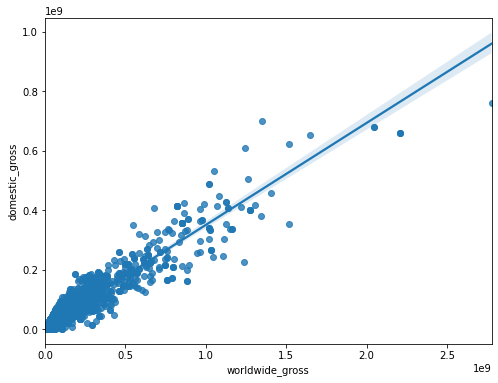

In [64]:
fig, ax1 = plt.subplots(figsize=(8, 6))
sns.regplot(data = master_clean, x ='worldwide_gross', y='domestic_gross', ax=ax1);
# There is a strong correlation between domestic and worldwide gross
# Let's use "worldwide gross" for calculating profit and roi to get a more comprehensive estimate. 

In [65]:
# Create profit and ROI columns:
master_clean['profit'] = master_clean['worldwide_gross'] - master_clean['production_budget'] 
master_clean['roi'] = ( (master_clean['worldwide_gross'] - master_clean['production_budget']) / master_clean['production_budget'] )*100


In [66]:
print(master_clean['profit'].median())
print(master_clean['roi'].median())
print(master_clean['production_budget'].quantile(q=(0,.25,.5, .75, 1)))

6597806.0
49.354005
0.00         1400.0
0.25      4500000.0
0.50     16000000.0
0.75     40000000.0
1.00    425000000.0
Name: production_budget, dtype: float64


**Create a categorical variable `roi_profit_bins` using the Median values for ROI and PROFIT as cutoff**:

- high ROI high profit: > 50% > 6.6 M
- high ROI low profit:  > 50% < 6.6 M
- low ROI high profit:  < 50% > 6.6 M
- low ROI low profit:   < 50% < 6.6 M

In [67]:
master_clean['roi_bins'] = master_clean['roi'].map(lambda x: '< 50%' if x<=master_clean['roi'].median() else ('> 50%'))
master_clean['profit_bins'] = master_clean['profit'].map(lambda x: '< 6.6 M' if x<=master_clean['profit'].median() else ('> 6.6 M'))
master_clean['roi_profit_bins'] = master_clean['roi_bins'] + ' ' + master_clean['profit_bins']


**Create a categorical variable `budget_bins` using the 4 quartiles as cutoff**:

- 0-4.5 M (lowest 25% of the data)
- 4.5-16 M (25-50th percentile)
- 16-40 M (50-75th percentile)
- 40-425 M (Top 25% percent)


In [68]:
master_clean['budget_bins'] = pd.qcut(master_clean['production_budget'], q=4, labels=['0-4.5 M', '4.5-16 M', '16-40 M', '40-425 M'])


In [69]:
master_clean.head()

,movie_id,primary_title,runtime_minutes,genres,averagerating,numvotes,director_name,release_date,production_budget,domestic_gross,worldwide_gross,release_year,profit,roi,roi_bins,profit_bins,roi_profit_bins,budget_bins
0,tt0249516,Foodfight,91.0,"Action,Animation,Comedy",1.9,8248.0,Lawrence Kasanoff,2012-12-31,45000000,0,73706,2012,-44926294,-99.836209,< 50%,< 6.6 M,< 50% < 6.6 M,40-425 M
1,tt0293429,Mortal Kombat,NaN,"Action,Adventure,Fantasy",NaN,NaN,Simon McQuoid,1995-08-18,20000000,70433227,122133227,1995,102133227,510.666135,> 50%,> 6.6 M,> 50% > 6.6 M,16-40 M
2,tt0326592,The Overnight,88.0,None,7.5,24.0,Jed I. Goodman,2015-06-19,200000,1109808,1165996,2015,965996,482.998000,> 50%,< 6.6 M,> 50% < 6.6 M,0-4.5 M
3,tt3844362,The Overnight,79.0,"Comedy,Mystery",6.1,14828.0,Patrick Brice,2015-06-19,200000,1109808,1165996,2015,965996,482.998000,> 50%,< 6.6 M,> 50% < 6.6 M,0-4.5 M
4,tt0337692,On the Road,124.0,"Adventure,Drama,Romance",6.1,37886.0,Walter Salles,2013-03-22,25000000,720828,9313302,2013,-15686698,-62.746792,< 50%,< 6.6 M,< 50% < 6.6 M,16-40 M


In [70]:
# MASTER dataset included duplicated entries due to multiple directors. 
# Drop these to create another dataset because 
# you do not want the same movie repeated for some of the analyses. 
master_clean_distinct = master_clean.copy()

In [71]:
master_clean_distinct['movie_id'].duplicated().sum()

432

In [72]:
master_clean_distinct = master_clean_distinct.drop_duplicates(subset='movie_id').reset_index(drop=True)

In [73]:
assert(master_clean_distinct['movie_id'].duplicated().sum() ==0)

In [74]:
len(master_clean_distinct['movie_id'])

3503

In [75]:
success_pivot = master_clean_distinct.pivot_table(index=['roi_bins','profit_bins'],
                                         values='roi',
                                         columns=['budget_bins'],
                                         aggfunc=['median','count'], fill_value=0 ) # Nan values replaced by 0 for table

success_pivot = success_pivot.style.format("{:.2f}").background_gradient(cmap='Purples', low=0, high=0.75)
success_pivot

#https://towardsdatascience.com/adding-style-to-pandas-in-just-a-few-lines-of-code-be942f65b3a5

**Table shows that:**
- **Low Roi - Low Profit** (Least Successful) movies have more lower budget movies but less ROI loss with higher budgets.
- **Low Roi - High Profit** movies have bigger budget movies only -  bigger room for more profit.
- **High Roi - Low Profit** movies have lower budget movies only -  bigger room for more return on investment. 
- **High Roi - High Profit** (Most Successful) movies have more higher budget movies but ROI gains were more for lower budget movies.

In [76]:
# Code copied from: https://stackoverflow.com/questions/61330427/set-y-axis-in-millions
# Replace millions with the following function to support all magnitudes:
from matplotlib.ticker import FuncFormatter

def human_format(num, pos):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000
    # add more suffixes if you need them
    return '$%.f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

formatter = FuncFormatter(human_format)

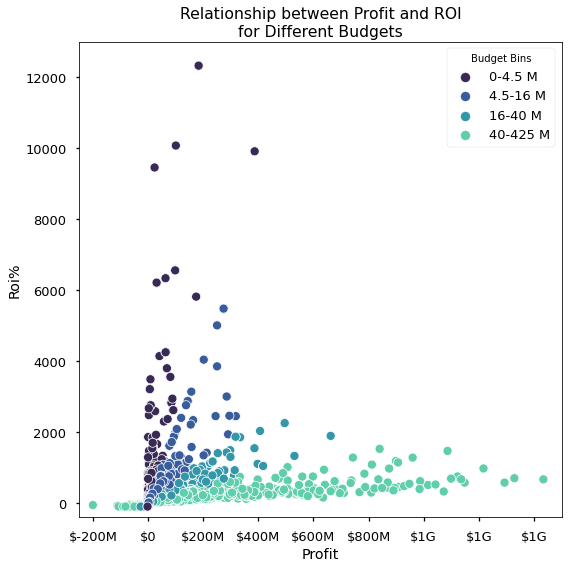

In [77]:
with plt.style.context('seaborn-talk'):
    fig, ax1  = plt.subplots(figsize=(8, 8))
    sns.scatterplot(data=master_clean_distinct, x='profit', y='roi', ax=ax1, hue='budget_bins', palette = "mako")
    
    ax1.set_title('Relationship between Profit and ROI\nfor Different Budgets')
    ax1.set_xlabel("Profit")
    ax1.set_ylabel("Roi%")
    legends = ax1.get_legend_handles_labels()[0]
    ax1.legend(title='Budget Bins')

    ax1.set_xlim(-250237650,1500000000) # removing 3 outliers for visualisation
    ax1.set_ylim(-400,13000) # removing 3 outliers for visualisation
    ax1.xaxis.set_major_formatter(formatter)
    
    fig.tight_layout()
    fig.savefig('./images/Scatterplot_RoiProfit.png', dpi=300);

### QUESTION1: WHICH MOVIE GENRES ARE MOST PROFITABLE?

In [78]:
df_genre = master_clean_distinct.copy()

In [79]:
df_genre = df_genre.drop(['runtime_minutes', 'numvotes', 'director_name', 'release_date'], axis=1)

In [80]:
df_genre.head()

,movie_id,primary_title,genres,averagerating,production_budget,domestic_gross,worldwide_gross,release_year,profit,roi,roi_bins,profit_bins,roi_profit_bins,budget_bins
0,tt0249516,Foodfight,"Action,Animation,Comedy",1.9,45000000,0,73706,2012,-44926294,-99.836209,< 50%,< 6.6 M,< 50% < 6.6 M,40-425 M
1,tt0293429,Mortal Kombat,"Action,Adventure,Fantasy",NaN,20000000,70433227,122133227,1995,102133227,510.666135,> 50%,> 6.6 M,> 50% > 6.6 M,16-40 M
2,tt0326592,The Overnight,None,7.5,200000,1109808,1165996,2015,965996,482.998000,> 50%,< 6.6 M,> 50% < 6.6 M,0-4.5 M
3,tt3844362,The Overnight,"Comedy,Mystery",6.1,200000,1109808,1165996,2015,965996,482.998000,> 50%,< 6.6 M,> 50% < 6.6 M,0-4.5 M
4,tt0337692,On the Road,"Adventure,Drama,Romance",6.1,25000000,720828,9313302,2013,-15686698,-62.746792,< 50%,< 6.6 M,< 50% < 6.6 M,16-40 M


In [81]:
df_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3503 entries, 0 to 3502
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   movie_id           3503 non-null   object  
 1   primary_title      3503 non-null   object  
 2   genres             3471 non-null   object  
 3   averagerating      2756 non-null   float64 
 4   production_budget  3503 non-null   int64   
 5   domestic_gross     3503 non-null   int64   
 6   worldwide_gross    3503 non-null   int64   
 7   release_year       3503 non-null   object  
 8   profit             3503 non-null   int64   
 9   roi                3503 non-null   float64 
 10  roi_bins           3503 non-null   object  
 11  profit_bins        3503 non-null   object  
 12  roi_profit_bins    3503 non-null   object  
 13  budget_bins        3503 non-null   category
dtypes: category(1), float64(2), int64(4), object(7)
memory usage: 359.5+ KB


In [82]:
# Dropping the 32 rows where Genre is null. 
df_genre = df_genre.dropna(subset=['genres']).reset_index(drop=True)

Issue: Many movies have **multiple genres**. Seperate them into distict columns to be able to analyze the data:

In [83]:
# In order to investigate seperate genre categories split the genres seperated by commas and expand them into different rows
# df_genre.explode('genres') This function expands to different rows.

df_genre['genres'] = df_genre['genres'].str.split(',')
df_genre = df_genre.explode('genres') # .explode() adds more rows
df_genre.head()

,movie_id,primary_title,genres,averagerating,production_budget,domestic_gross,worldwide_gross,release_year,profit,roi,roi_bins,profit_bins,roi_profit_bins,budget_bins
0,tt0249516,Foodfight,Action,1.9,45000000,0,73706,2012,-44926294,-99.836209,< 50%,< 6.6 M,< 50% < 6.6 M,40-425 M
0,tt0249516,Foodfight,Animation,1.9,45000000,0,73706,2012,-44926294,-99.836209,< 50%,< 6.6 M,< 50% < 6.6 M,40-425 M
0,tt0249516,Foodfight,Comedy,1.9,45000000,0,73706,2012,-44926294,-99.836209,< 50%,< 6.6 M,< 50% < 6.6 M,40-425 M
1,tt0293429,Mortal Kombat,Action,NaN,20000000,70433227,122133227,1995,102133227,510.666135,> 50%,> 6.6 M,> 50% > 6.6 M,16-40 M
1,tt0293429,Mortal Kombat,Adventure,NaN,20000000,70433227,122133227,1995,102133227,510.666135,> 50%,> 6.6 M,> 50% > 6.6 M,16-40 M


In [84]:
df_genre.info()
# This gives us 7335 data points to work on. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7335 entries, 0 to 3470
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   movie_id           7335 non-null   object  
 1   primary_title      7335 non-null   object  
 2   genres             7335 non-null   object  
 3   averagerating      6224 non-null   float64 
 4   production_budget  7335 non-null   int64   
 5   domestic_gross     7335 non-null   int64   
 6   worldwide_gross    7335 non-null   int64   
 7   release_year       7335 non-null   object  
 8   profit             7335 non-null   int64   
 9   roi                7335 non-null   float64 
 10  roi_bins           7335 non-null   object  
 11  profit_bins        7335 non-null   object  
 12  roi_profit_bins    7335 non-null   object  
 13  budget_bins        7335 non-null   category
dtypes: category(1), float64(2), int64(4), object(7)
memory usage: 809.6+ KB


In [85]:
df_genre.groupby("genres")['movie_id'].count().sort_values()

genres
Reality-TV        1
News              6
Western          24
Musical          27
War              45
Sport            71
Music            85
History          86
Animation       139
Family          178
Fantasy         178
Sci-Fi          224
Biography       231
Mystery         238
Romance         360
Crime           395
Horror          399
Documentary     420
Adventure       471
Thriller        570
Action          655
Comedy          839
Drama          1693
Name: movie_id, dtype: int64

In [86]:
# select those genres which produced at least 50 movies to be able to draw reliable conclusions:
df_genre = df_genre.groupby("genres").filter(lambda x: len(x) > 50) 
df_genre.groupby("genres")['movie_id'].count()

genres
Action          655
Adventure       471
Animation       139
Biography       231
Comedy          839
Crime           395
Documentary     420
Drama          1693
Family          178
Fantasy         178
History          86
Horror          399
Music            85
Mystery         238
Romance         360
Sci-Fi          224
Sport            71
Thriller        570
Name: movie_id, dtype: int64

In [87]:
df_genre.describe().apply(lambda x: x.apply('{0:.0f}'.format))
# The magnitudes are huge, we need format the magnitudes in the visualization

,averagerating,production_budget,domestic_gross,worldwide_gross,profit,roi
count,6147,7232,7232,7232,7232,7232
mean,6,36603264,44744886,108883921,72280657,269
std,1,49068636,76187965,209185422,173920711,1357
min,2,1400,0,0,-200237650,-100
25%,6,5000000,538690,2611750,-2693352,-65
50%,6,18000000,17630465,30627836,9958228,59
75%,7,45000000,53862963,109738840,68640345,253
max,9,425000000,760507625,2776345279,2351345279,41556


Create histograms to see if the continuous variables are normally distributed or skewed:

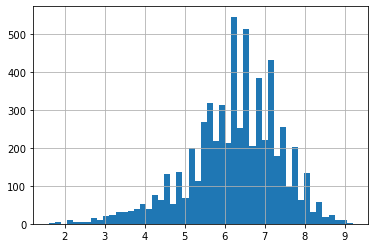

In [88]:
df_genre['averagerating'].hist(bins=50);

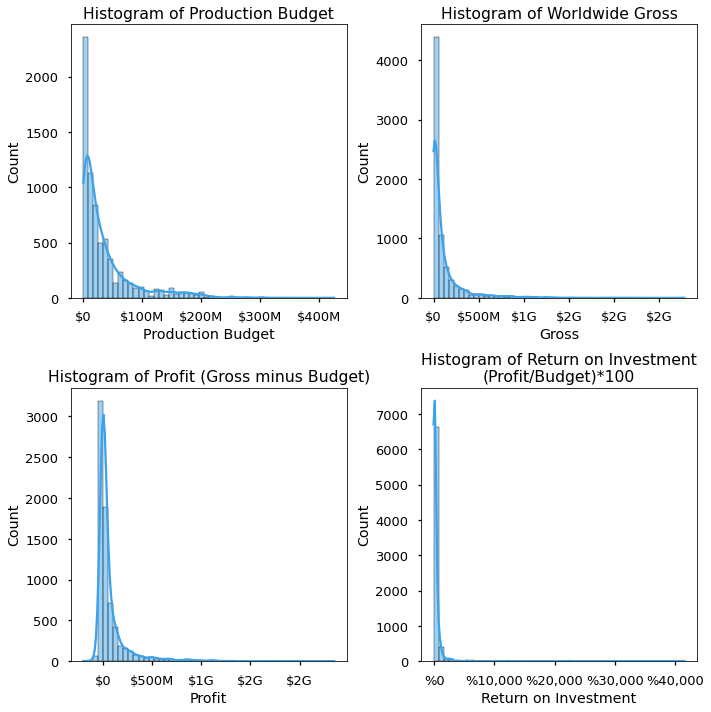

In [89]:
with plt.style.context('seaborn-talk'):
    fig, ( (ax1, ax2),(ax3, ax4))  = plt.subplots(ncols=2, nrows= 2, figsize=(10, 10))
    base_color = sns.color_palette("husl", 9)[6]
    
    sns.histplot(x = df_genre['production_budget'], bins = 50, ax=ax1, kde =True, color =base_color )
    sns.histplot(x = df_genre['worldwide_gross'], bins = 50, ax=ax2, kde =True, color =base_color )
    sns.histplot(x = df_genre['profit'], bins = 50, ax=ax3, kde =True, color =base_color )
    sns.histplot(x = df_genre['roi'], bins = 50, ax=ax4, kde =True, color =base_color )
    
    ax1.xaxis.set_major_formatter(formatter)
    ax2.xaxis.set_major_formatter(formatter)
    ax3.xaxis.set_major_formatter(formatter)

    # UserWarning: FixedFormatter should only be used together with FixedLocator
    # Set the locator first before prividing the format:
    ax4.xaxis.set_major_locator(mpl.ticker.MultipleLocator(10000))
    ax4.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) # plt.yticks(rotation=25)

    ax1.set_title('Histogram of Production Budget')
    ax2.set_title('Histogram of Worldwide Gross')
    ax3.set_title('Histogram of Profit (Gross minus Budget)')
    ax4.set_title('Histogram of Return on Investment\n(Profit/Budget)*100')

    ax1.set_xlabel("Production Budget")
    ax2.set_xlabel("Gross")
    ax3.set_xlabel("Profit")
    ax4.set_xlabel("Return on Investment")

    fig.tight_layout();
    fig.savefig('./images/Histograms_DependentMeasures.png', dpi=300);
# All of the variables are highly skewed except average rating. 

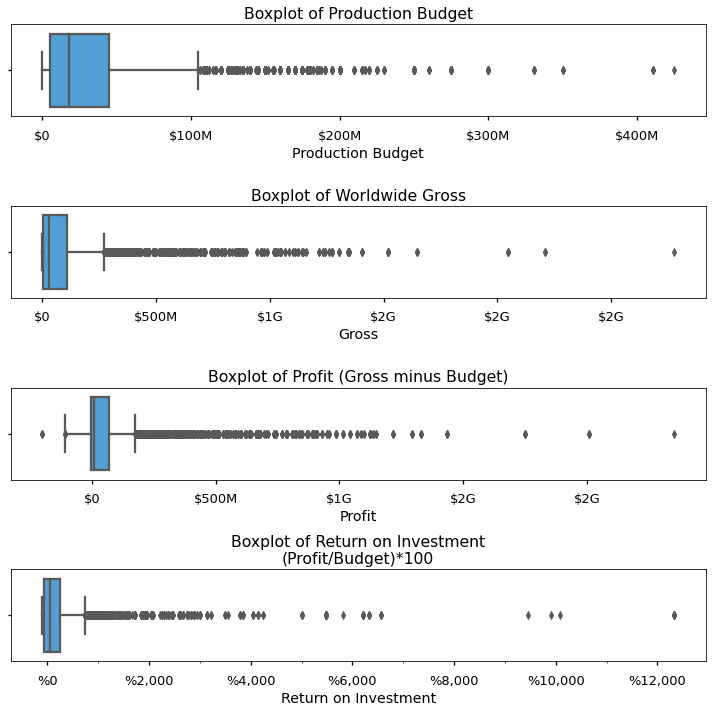

In [90]:
with plt.style.context('seaborn-talk'):
    fig, ( (ax1), (ax2),(ax3), (ax4))  = plt.subplots(ncols=1, nrows= 4, figsize=(10, 10))
    base_color = sns.color_palette("husl", 9)[6]
    
    sns.boxplot(x = df_genre['production_budget'], ax=ax1, color =base_color )
    sns.boxplot(x = df_genre['worldwide_gross'], ax=ax2, color =base_color )
    sns.boxplot(x = df_genre['profit'], ax=ax3, color =base_color )
    sns.boxplot(x = df_genre[df_genre['roi']<20000]['roi'], ax=ax4, color =base_color )
    
    ax1.xaxis.set_major_formatter(formatter)
    ax2.xaxis.set_major_formatter(formatter)
    ax3.xaxis.set_major_formatter(formatter)
    ax4.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2000))
    ax4.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1000))
    ax4.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) # plt.yticks(rotation=25)
    
    ax1.set_title('Boxplot of Production Budget')
    ax2.set_title('Boxplot of Worldwide Gross')
    ax3.set_title('Boxplot of Profit (Gross minus Budget)')
    ax4.set_title('Boxplot of Return on Investment\n(Profit/Budget)*100')

    ax1.set_xlabel("Production Budget")
    ax2.set_xlabel("Gross")
    ax3.set_xlabel("Profit")
    ax4.set_xlabel("Return on Investment")

    fig.tight_layout();
    fig.savefig('./images/Boxplots_DependentMeasures.png', dpi=300);
# All of the variables are highly skewed except average rating. 

- Almost all dependent variables are highly skewed except average rating. 
- There are many movies with extremely high budget, gross, profit or roi.
- ROI has the highest skew with the most expreme values. 

In [91]:
# Create 4 different dataframes in a specific budget bin:
dfbudgets = []
df_original = master_clean_distinct
q= ['0-4.5 M','4.5-16 M','16-40 M','40-425 M']
for i in range(0,len(q)):
    dfnew = df_original[df_original['budget_bins'] == q[i]]
    dfbudgets.append(dfnew)
    
print(dfbudgets[0].head(2))
print(dfbudgets[1].head(2))

    movie_id  primary_title  runtime_minutes          genres  averagerating  \
2  tt0326592  The Overnight             88.0            None            7.5   
3  tt3844362  The Overnight             79.0  Comedy,Mystery            6.1   

   numvotes   director_name release_date  production_budget  domestic_gross  \
2      24.0  Jed I. Goodman   2015-06-19             200000         1109808   
3   14828.0   Patrick Brice   2015-06-19             200000         1109808   

   worldwide_gross release_year  profit      roi roi_bins profit_bins  \
2          1165996         2015  965996  482.998    > 50%     < 6.6 M   
3          1165996         2015  965996  482.998    > 50%     < 6.6 M   

  roi_profit_bins budget_bins  
2   > 50% < 6.6 M     0-4.5 M  
3   > 50% < 6.6 M     0-4.5 M  
     movie_id   primary_title  runtime_minutes                   genres  \
20  tt0403935  Action Jackson            144.0          Action,Thriller   
23  tt0431021  The Possession             92.0  Horror,Mys

Based on 4 different budget ranges create different histograms to see if data is still skewed:

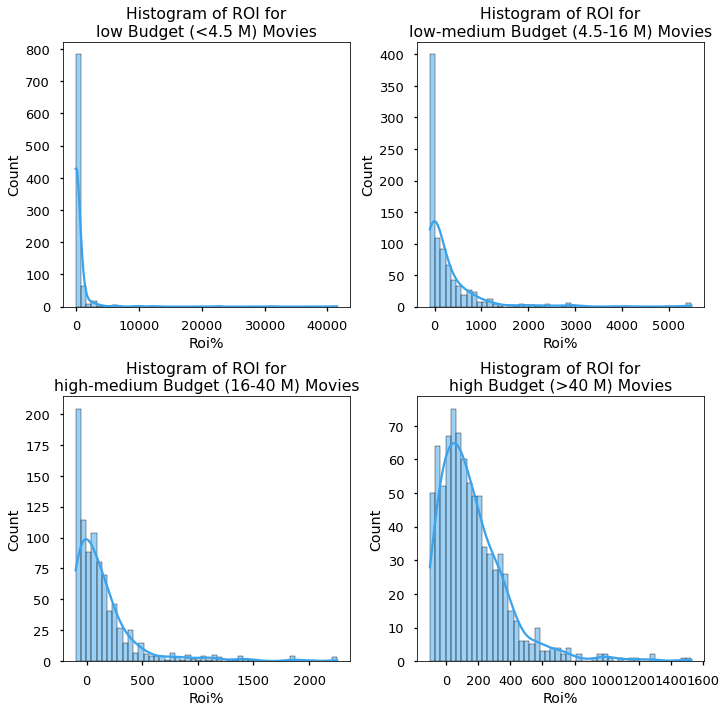

In [92]:
with plt.style.context('seaborn-talk'):
    fig, ( (ax1, ax2),(ax3, ax4) )  = plt.subplots(ncols=2, nrows= 2, figsize=(10, 10))
    base_color = sns.color_palette("husl", 9)[6]
    
    sns.histplot(x = dfbudgets[0]['roi'], bins = 50, ax=ax1, kde =True, color =base_color )
    sns.histplot(x = dfbudgets[1]['roi'], bins = 50, ax=ax2, kde =True, color =base_color )
    sns.histplot(x = dfbudgets[2]['roi'], bins = 50, ax=ax3, kde =True, color =base_color )
    sns.histplot(x = dfbudgets[3]['roi'], bins = 50, ax=ax4, kde =True, color =base_color )
    
    ax1.set_title('Histogram of ROI for\nlow Budget (<4.5 M) Movies')
    ax2.set_title('Histogram of ROI for\nlow-medium Budget (4.5-16 M) Movies')
    ax3.set_title('Histogram of ROI for\nhigh-medium Budget (16-40 M) Movies')
    ax4.set_title('Histogram of ROI for\nhigh Budget (>40 M) Movies')
    
    ax1.set_xlabel("Roi%")
    ax2.set_xlabel("Roi%")
    ax3.set_xlabel("Roi%")
    ax4.set_xlabel("Roi%")
    
    fig.tight_layout();
# Roi distribution is still highly skewed for the low, low-medium and high-medium 
# It is less skewed for high budget movies. 


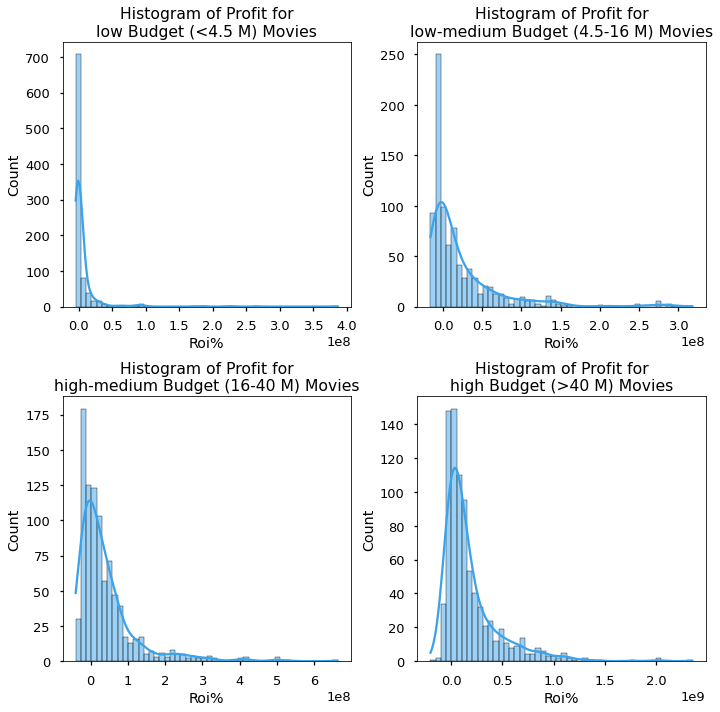

In [93]:
with plt.style.context('seaborn-talk'):
    fig, ( (ax1, ax2),(ax3, ax4) )  = plt.subplots(ncols=2, nrows= 2, figsize=(10, 10))
    base_color = sns.color_palette("husl", 9)[6]
    
    sns.histplot(x = dfbudgets[0]['profit'], bins = 50, ax=ax1, kde =True, color =base_color )
    sns.histplot(x = dfbudgets[1]['profit'], bins = 50, ax=ax2, kde =True, color =base_color )
    sns.histplot(x = dfbudgets[2]['profit'], bins = 50, ax=ax3, kde =True, color =base_color )
    sns.histplot(x = dfbudgets[3]['profit'], bins = 50, ax=ax4, kde =True, color =base_color )
    
    ax1.set_title('Histogram of Profit for\nlow Budget (<4.5 M) Movies')
    ax2.set_title('Histogram of Profit for\nlow-medium Budget (4.5-16 M) Movies')
    ax3.set_title('Histogram of Profit for\nhigh-medium Budget (16-40 M) Movies')
    ax4.set_title('Histogram of Profit for\nhigh Budget (>40 M) Movies')
    
    ax1.set_xlabel("Roi%")
    ax2.set_xlabel("Roi%")
    ax3.set_xlabel("Roi%")
    ax4.set_xlabel("Roi%")
    
    fig.tight_layout();
    
# Profit distribution is highly skewed for the low and low-medium 
# It is more normal for high-medium and especially for high, also in comparison to ROI. 

In [94]:
# Create a table with mean and median roi and profit values to use in visualisation:
df_genre_table = df_genre.groupby('genres')[['profit', 'roi']].agg(['mean', 'median','count'])
df_genre_table.reset_index(inplace=True)
df_genre_table

genres        profit                            roi                  
                         mean       median count        mean      median count
0        Action  1.204235e+08   28393687.0   655  231.529534   76.968172   655
1     Adventure  2.047587e+08   71306500.0   471  187.487157  131.278815   471
2     Animation  2.235153e+08  133691277.0   139  328.931906  175.320107   139
3     Biography  4.328547e+07    5910210.0   231  317.408067   56.871648   231
4        Comedy  6.889383e+07   14549338.0   839  253.673775   85.954617   839
5         Crime  3.779599e+07    2599159.0   395  122.835674   25.743070   395
6   Documentary  3.402774e+07    1495262.0   420  232.427077   19.538824   420
7         Drama  3.530952e+07    2502141.0  1693  218.099826   30.260742  1693
8        Family  9.632506e+07   18178226.0   178  259.756893   85.018198   178
9       Fantasy  1.419073e+08   28914614.0   178  298.520219   99.294160   178
10      History  3.693972e+07    4270222.5    86   99.815887   34.596546    86
11       Horror  4.513229e+07    4714370.0   399  545.536431   48.345155   399
12        Music  4.162830e+07    3339868.0    85  214.997588   49.166775    85
13      Mystery  5.134784e+07   14199690.0   238  602.710191   96.989125   238
14      Romance  3.376169e+07    5613768.0   360  287.340759   61.712829   360
15       Sci-Fi  1.652511e+08   24006658.5   224  199.494726  119.611842   224
16        Sport  4.484702e+07    -175000.0    71  297.346925   -7.119100    71
17     Thriller  4.884496e+07    2267819.0   570  356.910132   38.061217   570

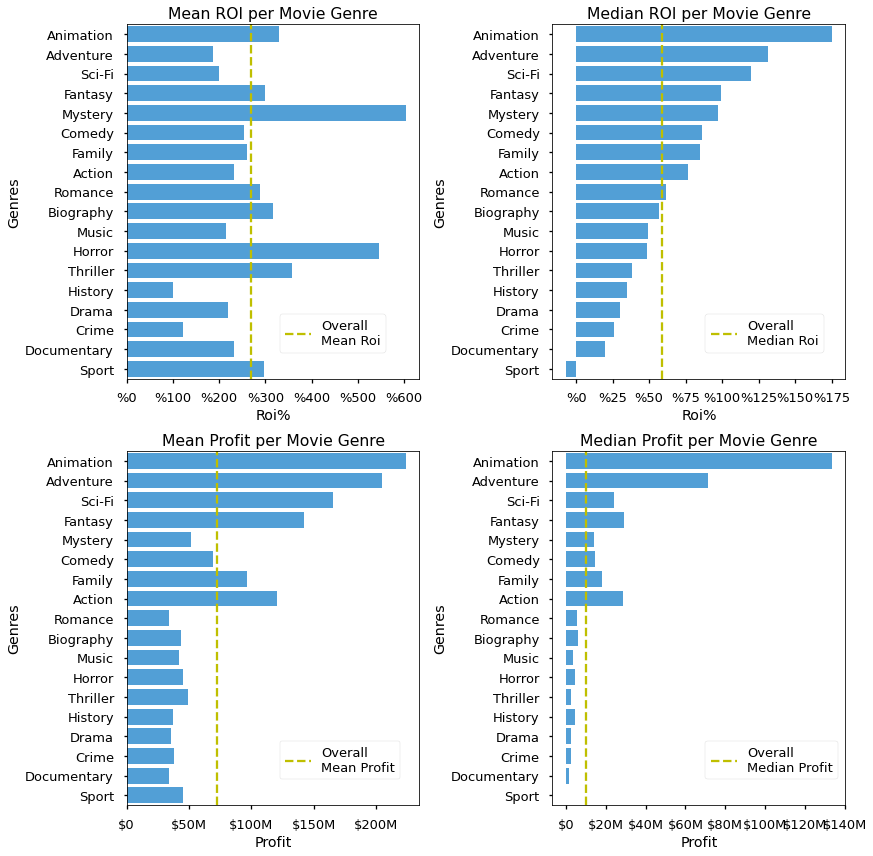

In [95]:
# Add a line to show the overall mean or median roi values for all movies.

df_genre_table = df_genre_table.sort_values([('roi','median')], ascending = False)
with plt.style.context('seaborn-talk'):
    base_color = sns.color_palette("husl", 9)[6]
    fig, ( (ax1, ax2), (ax3, ax4) ) = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))

    sns.barplot(x = df_genre_table['roi','mean'], y= df_genre_table['genres'], ax=ax1, color = base_color)
    sns.barplot(x = df_genre_table['roi','median'], y= df_genre_table['genres'], ax=ax2, color = base_color)
    sns.barplot(x = df_genre_table['profit','mean'], y= df_genre_table['genres'],  ax=ax3, color = base_color)
    sns.barplot(x = df_genre_table['profit','median'], y= df_genre_table['genres'],  ax=ax4, color = base_color)
    
    
    mean_roi = round(df_genre['roi'].mean())
    median_roi = round(df_genre['roi'].median())
    mean_profit = round(df_genre['profit'].mean())
    median_profit = round(df_genre['profit'].median())
    
    ax1.axvline(x= mean_roi, ymin=0, ymax=1, color='y', linestyle='--', label = "Overall\nMean Roi")  #label = f"Overall Mean Roi= {mean_roi:,.0f}%"
    ax1.legend(bbox_to_anchor = (0.5, 0.2), loc = 'upper left')
    ax2.axvline(x= median_roi, ymin=0, ymax=1, color='y', linestyle='--', label = "Overall\nMedian Roi")
    ax2.legend(bbox_to_anchor = (0.5, 0.2), loc = 'upper left')
    ax3.axvline(x= mean_profit, ymin=0, ymax=1, color='y', linestyle='--', label = "Overall\nMean Profit")
    ax3.legend(bbox_to_anchor = (0.5, 0.2), loc = 'upper left')
    ax4.axvline(x= median_profit, ymin=0, ymax=1, color='y', linestyle='--', label = "Overall\nMedian Profit")
    ax4.legend(bbox_to_anchor = (0.5, 0.2), loc = 'upper left')
    
    
    ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100))
    ax1.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}')) # plt.yticks(rotation=25)
    ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(25))
    ax2.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('%{x:,.0f}'))
    ax3.xaxis.set_major_formatter(formatter)
    ax4.xaxis.set_major_formatter(formatter)
    
    ax1.set_title('Mean ROI per Movie Genre')
    ax2.set_title('Median ROI per Movie Genre')
    ax3.set_title('Mean Profit per Movie Genre')
    ax4.set_title('Median Profit per Movie Genre')
    
    ax1.set_xlabel("Roi%")
    ax2.set_xlabel("Roi%")
    ax3.set_xlabel("Profit")
    ax4.set_xlabel("Profit")
    ax1.set_ylabel("Genres")
    ax2.set_ylabel("Genres")
    ax3.set_ylabel("Genres")
    ax4.set_ylabel("Genres")
    
    fig.tight_layout();
    fig.savefig('./images/MeanMedian_RoiProfit.png', dpi=300);
     

#### Should we rely on MEAN or MEDIAN?

- The discreancy on the mean versus median roi per genres stem from the outliers present. The value of the mean is distorted by the outliers. 
- There are some really low budget but high profit and ROI movies especailly in the Horror and Mysery genres (think of Paranormal Activity or The Blair Witch Project). On the other hand it is hard to make a successful movie with a low budget in the Animation or Sci-Fi genres. 
- We should rely on Median rather than mean since it would give us a more realistic and less risky approach. In reality more movies end up being unsuccessful.  
- There is less discrepancy in the mean versus median profit values per genres probably due to the outliers not being as extreme as in the case of roi. 

What **percentage of movies** belong to **high profit & high roi** category in each genre?

Let's also calculate the proportion of high profit & high roi movies in each genre to include into the above summary table:


In [96]:
proportion_highprofitroi = ((df_genre[df_genre['roi_profit_bins']== '> 50% > 6.6 M']\
                             .groupby('genres')['movie_id'].count())*100)\
                            /(df_genre.groupby('genres')['movie_id'].count())

In [97]:
proportion_highprofitroi = pd.DataFrame(data = proportion_highprofitroi)
proportion_highprofitroi = proportion_highprofitroi.reset_index()
proportion_highprofitroi.rename(columns={'movie_id' : 'proportion'}, inplace=True)
proportion_highprofitroi.head()

,genres,proportion
0,Action,53.587786
1,Adventure,64.543524
2,Animation,71.942446
3,Biography,48.051948
4,Comedy,53.277712


In [98]:
# Adding the proportion array into the tabel with a new column named proportion
# You need to make sure index are the same between the two df. 
df_genre_table['proportion'] = proportion_highprofitroi['proportion'] 
df_genre_table

genres        profit                            roi              \
                         mean       median count        mean      median   
2     Animation  2.235153e+08  133691277.0   139  328.931906  175.320107   
1     Adventure  2.047587e+08   71306500.0   471  187.487157  131.278815   
15       Sci-Fi  1.652511e+08   24006658.5   224  199.494726  119.611842   
9       Fantasy  1.419073e+08   28914614.0   178  298.520219   99.294160   
13      Mystery  5.134784e+07   14199690.0   238  602.710191   96.989125   
4        Comedy  6.889383e+07   14549338.0   839  253.673775   85.954617   
8        Family  9.632506e+07   18178226.0   178  259.756893   85.018198   
0        Action  1.204235e+08   28393687.0   655  231.529534   76.968172   
14      Romance  3.376169e+07    5613768.0   360  287.340759   61.712829   
3     Biography  4.328547e+07    5910210.0   231  317.408067   56.871648   
12        Music  4.162830e+07    3339868.0    85  214.997588   49.166775   
11       Horror  4.513229e+07    4714370.0   399  545.536431   48.345155   
17     Thriller  4.884496e+07    2267819.0   570  356.910132   38.061217   
10      History  3.693972e+07    4270222.5    86   99.815887   34.596546   
7         Drama  3.530952e+07    2502141.0  1693  218.099826   30.260742   
5         Crime  3.779599e+07    2599159.0   395  122.835674   25.743070   
6   Documentary  3.402774e+07    1495262.0   420  232.427077   19.538824   
16        Sport  4.484702e+07    -175000.0    71  297.346925   -7.119100   

         proportion  
   count             
2    139  71.942446  
1    471  64.543524  
15   224  54.910714  
9    178  54.494382  
13   238  49.159664  
4    839  53.277712  
8    178  53.370787  
0    655  53.587786  
14   360  45.833333  
3    231  48.051948  
12    85  44.705882  
11   399  45.363409  
17   570  44.210526  
10    86  44.186047  
7   1693  41.228588  
5    395  40.253165  
6    420  37.619048  
16    71  33.802817

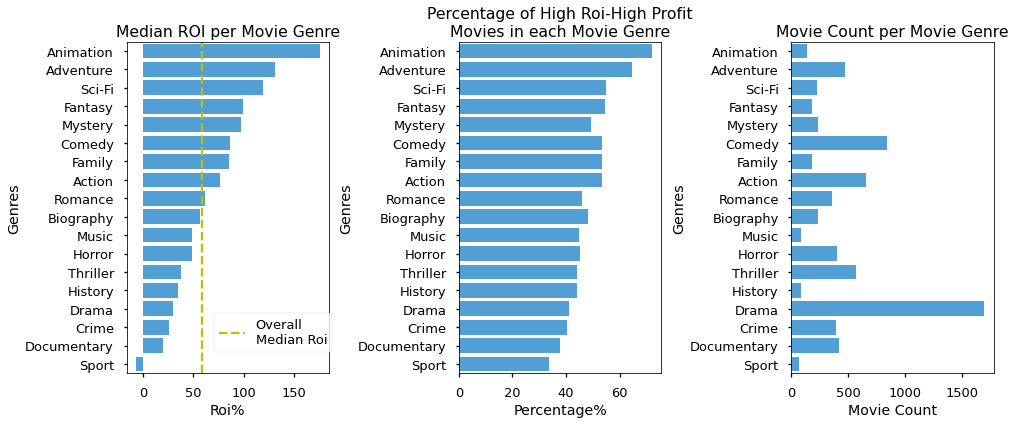

In [99]:
# Add a line to show the overall_median_roi for all movies.

df_genre_table = df_genre_table.sort_values([('roi','median')], ascending = False)
with plt.style.context('seaborn-talk'):
    base_color = sns.color_palette("husl", 9)[6]
    fig, ( (ax1, ax2, ax3) ) = plt.subplots(ncols=3, figsize=(14, 6))

    sns.barplot(x = df_genre_table['roi','median'], y= df_genre_table['genres'], ax=ax1, color = base_color) 
    ax1.axvline(x= df_genre['roi'].median(), ymin=0, ymax=1, color='y', linestyle='--', label = 'Overall\nMedian Roi')
    ax1.legend(bbox_to_anchor = (0.4, 0.2), loc = 'upper left')
    
    sns.barplot(x = df_genre_table['proportion'], y= df_genre_table['genres'], ax=ax2, color = base_color) 
    sns.barplot(x = df_genre_table['roi','count'], y= df_genre_table['genres'],  ax=ax3, color = base_color)

    ax1.set_title('Median ROI per Movie Genre')
    ax2.set_title('Percentage of High Roi-High Profit\nMovies in each Movie Genre')
    ax3.set_title('Movie Count per Movie Genre')
    
    ax1.set_xlabel("Roi%")
    ax2.set_xlabel("Percentage%")
    ax3.set_xlabel("Movie Count")

    ax1.set_ylabel("Genres")
    ax2.set_ylabel("Genres")
    ax3.set_ylabel("Genres")
    
    fig.tight_layout();
    fig.savefig('./images/RoiMedianPropCount.jpeg', dpi=300)

Can we also make specific inferences for each **budget range** about which movie genres are more profitable?

In [100]:
def slicing(df_original, q, var):
    dfbudgets_tables = []
    for i in range(0,len(q)):
        dfnew = df_original[df_original['budget_bins'] == q[i]]
        dfnew = dfnew.groupby("genres").filter(lambda x: len(x) >= 20) 
        dfnew = pd.DataFrame(dfnew.groupby('genres')[var].median()).reset_index()
        dfbudgets_tables.append(dfnew)
    return dfbudgets_tables

In [101]:
df_original = df_genre
q= ['0-4.5 M','4.5-16 M','16-40 M','40-425 M']
var = 'roi'
dfbudgets_tables_roi = slicing(df_original, q, var)

df_original = df_genre
q= ['0-4.5 M','4.5-16 M','16-40 M','40-425 M']
var = 'profit'
dfbudgets_tables_profit = slicing(df_original, q, var)

print(dfbudgets_tables_roi[0].head(2))
print(dfbudgets_tables_profit[3].head(2))

      genres        roi
0     Action -99.237486
1  Adventure -98.227900
      genres       profit
0     Action  136246291.5
1  Adventure  213500000.0


In [102]:
dfbudgets_tables_profit[0]

,genres,profit
0,Action,-500000.0
1,Adventure,-888250.0
2,Biography,-443781.0
3,Comedy,-480200.0
4,Crime,-750000.0
5,Documentary,-250000.0
6,Drama,-250000.0
7,Family,-250000.0
8,Fantasy,205670.0
9,Horror,-351654.5


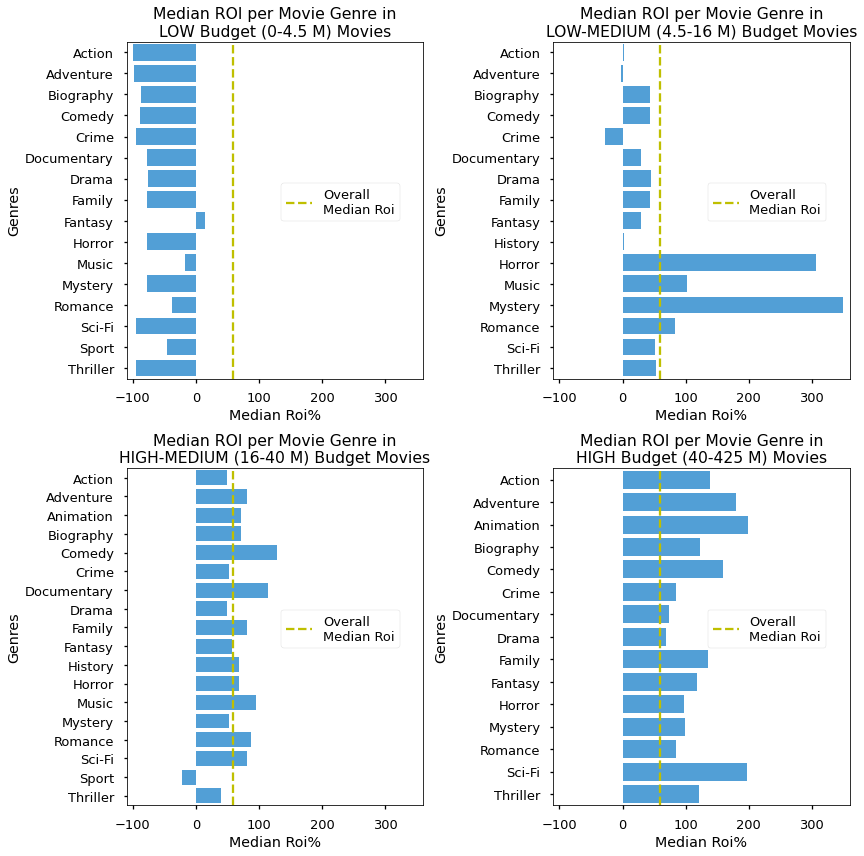

In [103]:
with plt.style.context('seaborn-talk'):
    fig, ( (ax1, ax2),(ax3, ax4) )  = plt.subplots(ncols=2, nrows= 2, figsize=(12, 12))
    base_color = sns.color_palette("husl", 9)[6]
    
    sns.barplot(data = dfbudgets_tables_roi[0], x = 'roi', y= 'genres', ax=ax1, color = base_color) 
    ax1.axvline(x= df_genre['roi'].median(), ymin=0, ymax=1, color='y', linestyle='--', label = 'Overall\nMedian Roi')
    ax1.legend(bbox_to_anchor = (0.5, 0.6), loc = 'upper left')
    
    sns.barplot(data = dfbudgets_tables_roi[1], x = 'roi', y= 'genres', ax=ax2, color = base_color) 
    ax2.axvline(x= df_genre['roi'].median(), ymin=0,ymax=1, color='y', linestyle='--', label = 'Overall\nMedian Roi')
    ax2.legend(bbox_to_anchor = (0.5, 0.6), loc = 'upper left')
    
    sns.barplot(data = dfbudgets_tables_roi[2], x = 'roi', y= 'genres', ax=ax3, color = base_color) 
    ax3.axvline(x= df_genre['roi'].median(), ymin=0, ymax=1, color='y', linestyle='--', label = 'Overall\nMedian Roi')
    ax3.legend(bbox_to_anchor = (0.5, 0.6), loc = 'upper left')
    
    sns.barplot(data = dfbudgets_tables_roi[3], x = 'roi', y= 'genres', ax=ax4, color = base_color) 
    ax4.axvline(x= df_genre['roi'].median(), ymin=0, ymax=1, color='y', linestyle='--', label = 'Overall\nMedian Roi')
    ax4.legend(bbox_to_anchor = (0.5, 0.6), loc = 'upper left')

    ax1.set_title('Median ROI per Movie Genre in\nLOW Budget (0-4.5 M) Movies')
    ax2.set_title('Median ROI per Movie Genre in\nLOW-MEDIUM (4.5-16 M) Budget Movies')
    ax3.set_title('Median ROI per Movie Genre in\nHIGH-MEDIUM (16-40 M) Budget Movies')
    ax4.set_title('Median ROI per Movie Genre in\nHIGH Budget (40-425 M) Movies')
    
    ax1.set_xlabel("Median Roi%")
    ax2.set_xlabel("Median Roi%")
    ax3.set_xlabel("Median Roi%")
    ax4.set_xlabel("Median Roi%")
    
    ax1.set_ylabel("Genres")
    ax2.set_ylabel("Genres")
    ax3.set_ylabel("Genres")
    ax4.set_ylabel("Genres")
    
    ax1.set_xlim(-110,360)
    ax2.set_xlim(-110,360)
    ax3.set_xlim(-110,360)
    ax4.set_xlim(-110,360)
    
    
    fig.tight_layout();
    fig.savefig('./images/Barplot_RoibyBudget.png', dpi=300);

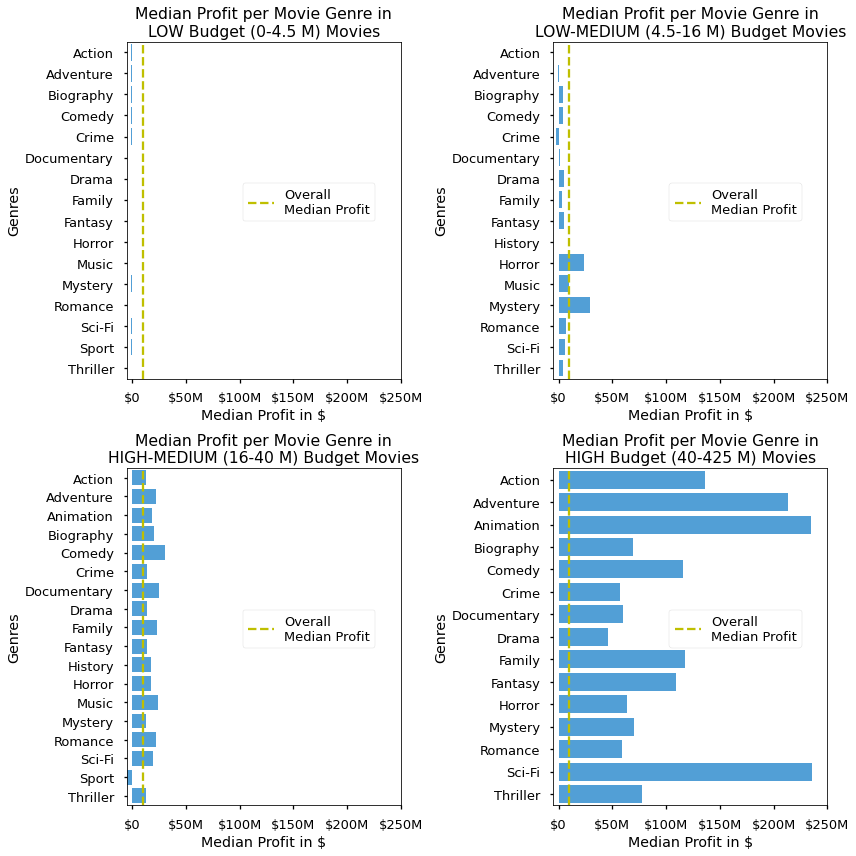

In [104]:
with plt.style.context('seaborn-talk'):
    fig, ( (ax1, ax2),(ax3, ax4) )  = plt.subplots(ncols=2, nrows= 2, figsize=(12, 12))
    base_color = sns.color_palette("husl", 9)[6]
    
    sns.barplot(data = dfbudgets_tables_profit[0], x = 'profit', y= 'genres', ax=ax1, color = base_color) 
    ax1.axvline(x= df_genre['profit'].median(), ymin=0, ymax=1, color='y', linestyle='--', label = 'Overall\nMedian Profit')
    ax1.legend(bbox_to_anchor = (0.4, 0.6), loc = 'upper left')
    
    sns.barplot(data = dfbudgets_tables_profit[1], x = 'profit', y= 'genres', ax=ax2, color = base_color) 
    ax2.axvline(x= df_genre['profit'].median(), ymin=0,ymax=1, color='y', linestyle='--', label = 'Overall\nMedian Profit')
    ax2.legend(bbox_to_anchor = (0.4, 0.6), loc = 'upper left')
    
    sns.barplot(data = dfbudgets_tables_profit[2], x = 'profit', y= 'genres', ax=ax3, color = base_color) 
    ax3.axvline(x= df_genre['profit'].median(), ymin=0, ymax=1, color='y', linestyle='--', label = 'Overall\nMedian Profit')
    ax3.legend(bbox_to_anchor = (0.4, 0.6), loc = 'upper left')
    
    sns.barplot(data = dfbudgets_tables_profit[3], x = 'profit', y= 'genres', ax=ax4, color = base_color) 
    ax4.axvline(x= df_genre['profit'].median(), ymin=0, ymax=1, color='y', linestyle='--', label = 'Overall\nMedian Profit')
    ax4.legend(bbox_to_anchor = (0.4, 0.6), loc = 'upper left')

    ax1.xaxis.set_major_formatter(formatter)
    ax2.xaxis.set_major_formatter(formatter)
    ax3.xaxis.set_major_formatter(formatter)
    ax4.xaxis.set_major_formatter(formatter)
    
    ax1.set_title('Median Profit per Movie Genre in\nLOW Budget (0-4.5 M) Movies')
    ax2.set_title('Median Profit per Movie Genre in\nLOW-MEDIUM (4.5-16 M) Budget Movies')
    ax3.set_title('Median Profit per Movie Genre in\nHIGH-MEDIUM (16-40 M) Budget Movies')
    ax4.set_title('Median Profit per Movie Genre in\nHIGH Budget (40-425 M) Movies')
    
    ax1.set_xlabel("Median Profit in $")
    ax2.set_xlabel("Median Profit in $")
    ax3.set_xlabel("Median Profit in $")
    ax4.set_xlabel("Median Profit in $")
    
    ax1.set_ylabel("Genres")
    ax2.set_ylabel("Genres")
    ax3.set_ylabel("Genres")
    ax4.set_ylabel("Genres")
    
    ax1.set_xlim(-5000000,250000000)
    ax2.set_xlim(-5000000,250000000)
    ax3.set_xlim(-5000000,250000000)
    ax4.set_xlim(-5000000,250000000)
    
    fig.tight_layout();
    fig.savefig('./images/Barplot_ProfitbyBudget.png', dpi=300);

Above visualisation show that:
- Low budget (<4.5 M) movies do not success in general. Avoid if possible. 
- 4.5-16 M budget range should invest on **Mystery and Horror** - for which the movies have a high chance of success with around 300% ROI or profiting three times as much as the cost. 
- 16-40 M budget range can invest on Comedy, Documentary, Music and Romance for about 100% ROI. 
- High budget (>40 M) movies should invest on **Animation, Adventure, Sci-Fi** rather than Mystery and Horror. But  the Return on investment for these higher budget movies are around 200% - profit is twice as much as the cost. Since the budget is high profit is also high in these movies, but ROI is less when compared with what percent Mystery and Horror would bring in the 4.5-16 range budget. 

PS: It is the precense of some Low Budget - High Gross HORROR-MYSTERY movies that skew the distribution.

#### JUST FOR FUN: WHAT IS THE MOST PROFITABLE MOVIE OF ALL TIMES BASED ON ROI?

In [105]:
df_genre['roi'].max()

41556.473999999995

In [106]:
df_genre[df_genre['roi'] == 41556.473999999995]

,movie_id,primary_title,genres,averagerating,production_budget,domestic_gross,worldwide_gross,release_year,profit,roi,roi_bins,profit_bins,roi_profit_bins,budget_bins
2281,tt2309260,The Gallows,Horror,4.2,100000,22764410,41656474,2015,41556474,41556.474,> 50%,> 6.6 M,> 50% > 6.6 M,0-4.5 M
2281,tt2309260,The Gallows,Mystery,4.2,100000,22764410,41656474,2015,41556474,41556.474,> 50%,> 6.6 M,> 50% > 6.6 M,0-4.5 M
2281,tt2309260,The Gallows,Thriller,4.2,100000,22764410,41656474,2015,41556474,41556.474,> 50%,> 6.6 M,> 50% > 6.6 M,0-4.5 M


From https://en.wikipedia.org/wiki/The_Gallows

"**The Gallows** was released in the United States by Warner Bros. Pictures and New Line Cinema on July 10, 2015. It was largely disliked by critics and audiences but grossed 43 million dollars worldwide against a 100,000 budget. A sequel, The Gallows Act II, was released in October 2019."


#### IS THERE A LINK BETWEEN RATING AND ROI? 
#### Can we use movie ratings as a way to assess profitability? 

In [107]:
df_rating_roi = master_clean_distinct.copy()

In [108]:
df_rating_roi['roinegpos'] = pd.cut(df_rating_roi['roi'], bins = [-100, 0, 20000], labels=['neg', 'pos'])

In [109]:
# Create dataframes for each bin:
dfroibins = []
df_original = df_rating_roi
q= ['neg',  'pos']
for i in range(0,len(q)):
    dfnew = df_original[df_original['roinegpos'] == q[i]]
    dfroibins.append(dfnew)
print(dfroibins[0].head(1))
print(dfroibins[1].head(1))

    movie_id primary_title  runtime_minutes                   genres  \
0  tt0249516     Foodfight             91.0  Action,Animation,Comedy   

   averagerating  numvotes      director_name release_date  production_budget  \
0            1.9    8248.0  Lawrence Kasanoff   2012-12-31           45000000   

   domestic_gross  worldwide_gross release_year    profit        roi roi_bins  \
0               0            73706         2012 -44926294 -99.836209    < 50%   

  profit_bins roi_profit_bins budget_bins roinegpos  
0     < 6.6 M   < 50% < 6.6 M    40-425 M       neg  
    movie_id  primary_title  runtime_minutes                    genres  \
1  tt0293429  Mortal Kombat              NaN  Action,Adventure,Fantasy   

   averagerating  numvotes  director_name release_date  production_budget  \
1            NaN       NaN  Simon McQuoid   1995-08-18           20000000   

   domestic_gross  worldwide_gross release_year     profit         roi  \
1        70433227        122133227         

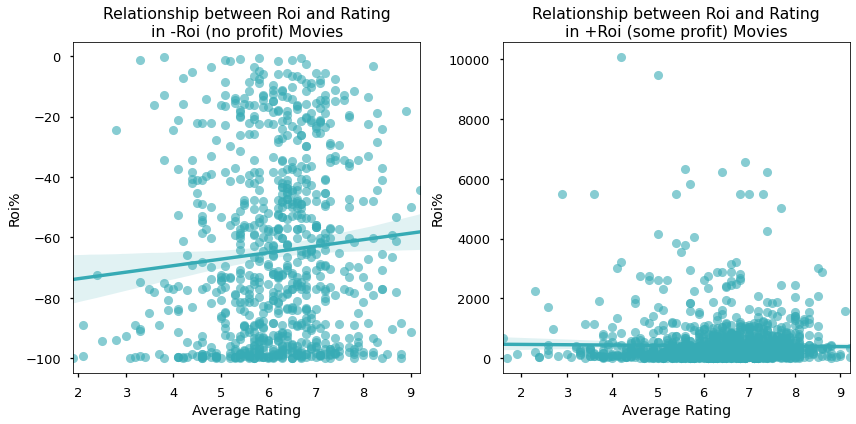

In [110]:
dfroibins[1] = dfroibins[1][dfroibins[1]['roi']<20000] 
# removing 4 outliers from the high roi graph for visualization purposes.

with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2) = plt.subplots(ncols=2,  figsize=(12, 6))
    
    base_color = sns.color_palette("husl", 9)[5]
    sns.regplot(data=dfroibins[0], x='averagerating', y='roi', ax=ax1, scatter_kws={'alpha':0.6}, color = base_color)
    sns.regplot(data=dfroibins[1], x='averagerating', y='roi', ax=ax2, scatter_kws={'alpha':0.6}, color = base_color)

    ax1.set_title('Relationship between Roi and Rating\nin -Roi (no profit) Movies')
    ax2.set_title('Relationship between Roi and Rating\nin +Roi (some profit) Movies')

    ax1.set_xlabel("Average Rating")
    ax2.set_xlabel("Average Rating")
    
    ax1.set_ylabel("Roi%")
    ax2.set_ylabel("Roi%")
    
    fig.tight_layout();
    fig.savefig('./images/Scatterplot_RatingPerRoi.png', dpi=300);
    

- Ratings could be misleading for assessing movie success.
- Do NOT rely on ratings when assessing a movie’s financial success if the movie makes >50% profit. 

### QUESTION 2: WHICH DIRECTORS SHOULD YOU WORK WITH?

In [111]:
df_director = master_clean.copy()

In [112]:
df_director_table = df_director.groupby('director_name')[['roi','profit','production_budget']].agg(['mean', 'count'])
df_director_table.reset_index(inplace=True)
df_director_table

director_name         roi             profit        \
                               mean count         mean count   
0       A.M. Sannazzaro  917.533662     1  133042381.0     1   
1     Aaron Agrasanchez   65.420546     1   22897191.0     1   
2            Aaron Alon  -34.198857     1    -718176.0     1   
3            Aaron Hann  -99.498800     1   -1989976.0     1   
4      Aaron Schnobrich   17.532050     1     350641.0     1   
...                 ...         ...   ...          ...   ...   
3211      Zoran Lisinac  -98.706400     1    -246766.0     1   
3212    Zsófia Szilágyi  294.457947     1   44168692.0     1   
3213      Zuri Rinpoche   88.944500     2   10673340.0     2   
3214       Éric Tessier   61.866663     1   18559999.0     1   
3215      Éric Toledano  -98.700400     1    -987004.0     1   

     production_budget        
                  mean count  
0           14500000.0     1  
1           35000000.0     1  
2            2100000.0     1  
3            2000000.0     1  
4            2000000.0     1  
...                ...   ...  
3211          250000.0     1  
3212        15000000.0     1  
3213        12000000.0     2  
3214        30000000.0     1  
3215         1000000.0     1  

[3216 rows x 7 columns]

In [113]:
df_director_top_roi = df_director_table.sort_values(by=[('roi','mean')], ascending = False).head(20)
df_director_top_roi.reset_index(drop = True, inplace=True)
df_director_top_roi.head()


director_name           roi             profit        \
                               mean count         mean count   
0        Chris Lofing  41556.474000     1   41556474.0     1   
1        Travis Cluff  41556.474000     1   41556474.0     1   
2  Sébastien Lifshitz  31135.431235     1  267142000.0     1   
3        Sujit Mondal  22400.000000     1  224000000.0     1   
4     Adnan A. Shaikh  22400.000000     1  224000000.0     1   

  production_budget        
               mean count  
0          100000.0     1  
1          100000.0     1  
2          858000.0     1  
3         1000000.0     1  
4         1000000.0     1

In [114]:
df_director_top_profit = df_director_table.sort_values(by=[('profit','mean')], ascending = False).head(20)
df_director_top_profit.reset_index(drop = True, inplace=True)
df_director_top_profit.head()

director_name          roi              profit       production_budget  \
                         mean count          mean count              mean   
0   Atsushi Wada   553.257713     1  2.351345e+09     1       425000000.0   
1  Kevin Lincoln  1004.104198     1  2.008208e+09     1       200000000.0   
2      Ravi Punj  1004.104198     1  2.008208e+09     1       200000000.0   
3     Pete Meads  1004.104198     1  2.008208e+09     1       200000000.0   
4   Jennifer Lee   748.313273     1  1.122470e+09     1       150000000.0   

         
  count  
0     1  
1     1  
2     1  
3     1  
4     1

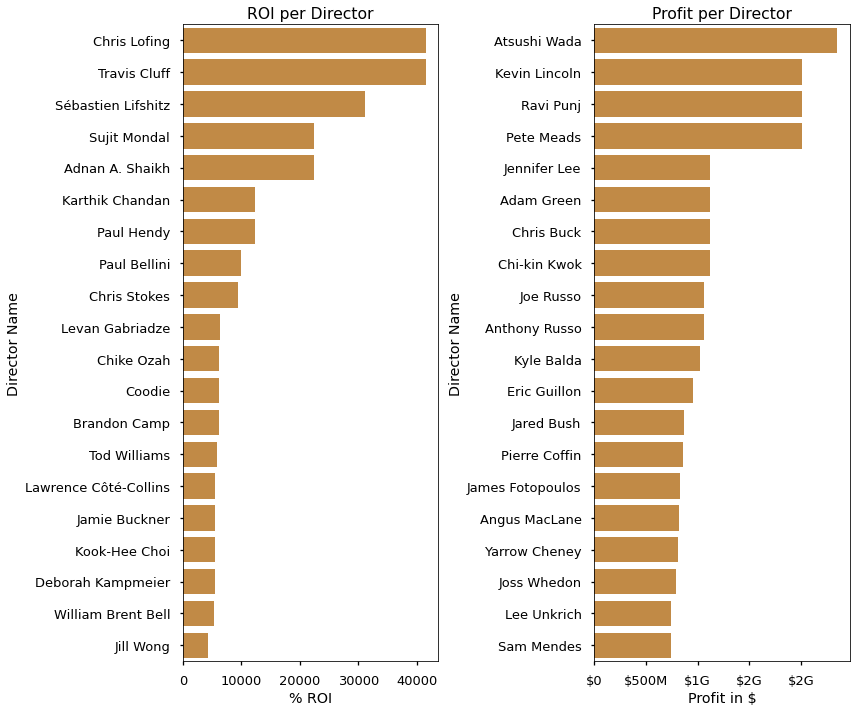

In [115]:
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 10))
    base_color = sns.color_palette("husl", 9)[1]
    
    sns.barplot(y= df_director_top_roi['director_name'], x= df_director_top_roi['roi', 'mean'], color = base_color, ax=ax1)
    sns.barplot(y= df_director_top_profit['director_name'], x= df_director_top_profit['profit', 'mean'],  color = base_color, ax=ax2)

    # Because roi and profit are continuous, you need to get the ticks location fixed first before rotating. 
    # Remove the decimal point from the labels by converting into an integer. 
    
    ticks_loc = ax1.get_xticks().tolist()
    ax1.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
    ax1.set_xticklabels(ax1.get_xticks().astype(int))
    
    ax2.xaxis.set_major_formatter(formatter)
    
    ax1.set_title('ROI per Director') 
    ax2.set_title("Profit per Director")
    
    ax1.set_xlabel("% ROI")
    ax2.set_xlabel("Profit in $")
    
    
    ax1.set_ylabel("Director Name")
    ax2.set_ylabel("Director Name")
    
    fig.tight_layout();
    fig.savefig('./images/Barplot_Directors.png', dpi=300);
    

In [116]:
def commonnames(list1, list2):
    commonlist = []
    for name in list1:
        if name in list2:
            commonlist.append(name) 
    return commonlist

In [117]:
list1 = list(df_director_top_roi['director_name'])
list2 = list(df_director_top_profit['director_name'])
commonnames(list1, list2)


[]

### QUESTION 3: WHICH MONTHS ARE THE BEST TO RELEASE A MOVIE?

In [118]:
df_months = master_clean_distinct.copy()  

In [119]:
# Extract a new column called release month using the release date. 
df_months['release_month'] =  pd.to_datetime(df_months['release_date']).dt.month

In [120]:
# Order the months so they appear in order from January to December:
df_months.sort_values(by='release_month', inplace=True)

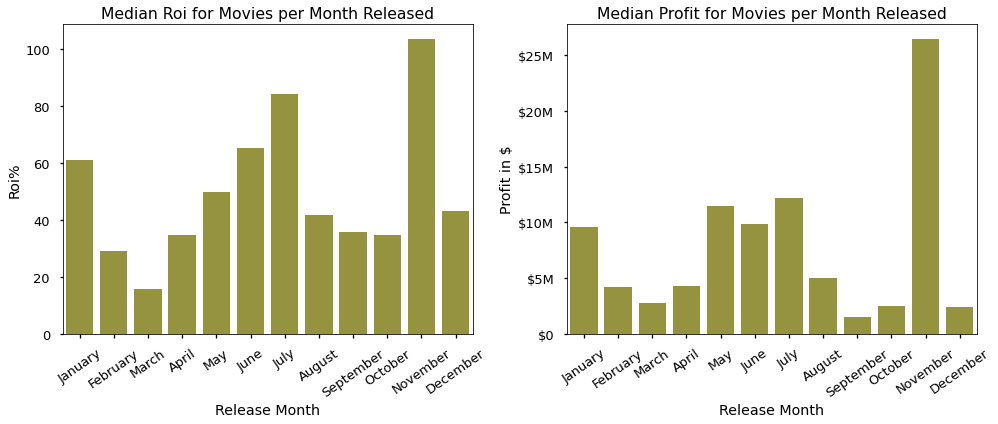

In [121]:
with plt.style.context('seaborn-talk'):
    fig, (ax1, ax2) = plt.subplots(figsize=(14,6), ncols=2)
    base_color = sns.color_palette("husl", 9)[2]
    
    sns.barplot(data=df_months, x='release_month', y='roi', estimator= np.median, ax=ax1, ci = None, color = base_color)
    sns.barplot(data=df_months, x='release_month', y='profit', estimator= np.median, ax=ax2, ci = None, color = base_color)
    
    ax1.set_xticklabels(labels = ['January','February','March','April','May','June',\
                                  'July','August','September','October','November','December']\
                                 ,rotation=35)  
    ax2.set_xticklabels(labels = ['January','February','March','April','May','June',\
                                 'July','August','September','October','November','December']\
                                  ,rotation=35)  

    ax2.yaxis.set_major_formatter(formatter)
    
    ax1.set_title('Median Roi for Movies per Month Released')
    ax2.set_title('Median Profit for Movies per Month Released')
    
    ax1.set_xlabel("Release Month")
    ax2.set_xlabel("Release Month")
    
    ax1.set_ylabel("Roi%")
    ax2.set_ylabel("Profit in $")
    
    fig.tight_layout();
    fig.savefig('./images/Barplot_ReleaseMonth.png', dpi=300);
    

* High returns on investment as well as profit occur mostly in the month of **November**. People probably go to more movies in the month of November right before the holiday season kicks in and the temperatures start to drop significantly (in the northern hemisphere). 
* Interestingly there is a sharp ***decline*** in ***December*** probably due to the busyness of the holiday season. But **January** - end of holiday season - sees a modest increase again in Roi and Profit. 
* **June and July** is also high in ROI and high in profit. With the high temperatures and the schools being closed people again might be going to the movies more than usual.

### QUESTION 4: WHAT IS A GOOD LENGTH TO AIM FOR A MOVIE?

In [122]:
df_length = master_clean_distinct.copy()  

In [123]:
df_length

,movie_id,primary_title,runtime_minutes,genres,averagerating,numvotes,director_name,release_date,production_budget,domestic_gross,worldwide_gross,release_year,profit,roi,roi_bins,profit_bins,roi_profit_bins,budget_bins
0,tt0249516,Foodfight,91.0,"Action,Animation,Comedy",1.9,8248.0,Lawrence Kasanoff,2012-12-31,45000000,0,73706,2012,-44926294,-99.836209,< 50%,< 6.6 M,< 50% < 6.6 M,40-425 M
1,tt0293429,Mortal Kombat,NaN,"Action,Adventure,Fantasy",NaN,NaN,Simon McQuoid,1995-08-18,20000000,70433227,122133227,1995,102133227,510.666135,> 50%,> 6.6 M,> 50% > 6.6 M,16-40 M
2,tt0326592,The Overnight,88.0,None,7.5,24.0,Jed I. Goodman,2015-06-19,200000,1109808,1165996,2015,965996,482.998000,> 50%,< 6.6 M,> 50% < 6.6 M,0-4.5 M
3,tt3844362,The Overnight,79.0,"Comedy,Mystery",6.1,14828.0,Patrick Brice,2015-06-19,200000,1109808,1165996,2015,965996,482.998000,> 50%,< 6.6 M,> 50% < 6.6 M,0-4.5 M
4,tt0337692,On the Road,124.0,"Adventure,Drama,Romance",6.1,37886.0,Walter Salles,2013-03-22,25000000,720828,9313302,2013,-15686698,-62.746792,< 50%,< 6.6 M,< 50% < 6.6 M,16-40 M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3498,tt9729206,Diner,NaN,Crime,NaN,NaN,Mika Ninagawa,1982-04-02,5000000,12592907,12592907,1982,7592907,151.858140,> 50%,> 6.6 M,> 50% > 6.6 M,4.5-16 M
3499,tt9805168,Traitor,110.0,"Action,Drama,Romance",NaN,NaN,Janchivdorj Sengedorj,2008-08-27,22000000,23530831,27882226,2008,5882226,26.737391,< 50%,< 6.6 M,< 50% < 6.6 M,16-40 M
3500,tt9844102,Ray,111.0,Crime,NaN,NaN,Riingo Banerjee,2004-10-29,40000000,75305995,124823094,2004,84823094,212.057735,> 50%,> 6.6 M,> 50% > 6.6 M,16-40 M
3501,tt9889814,Kiss Kiss Bang Bang,98.0,"Crime,Romance,Thriller",NaN,NaN,Karthik Medikonda,2005-10-21,15000000,4235837,16829464,2005,1829464,12.196427,< 50%,< 6.6 M,< 50% < 6.6 M,4.5-16 M


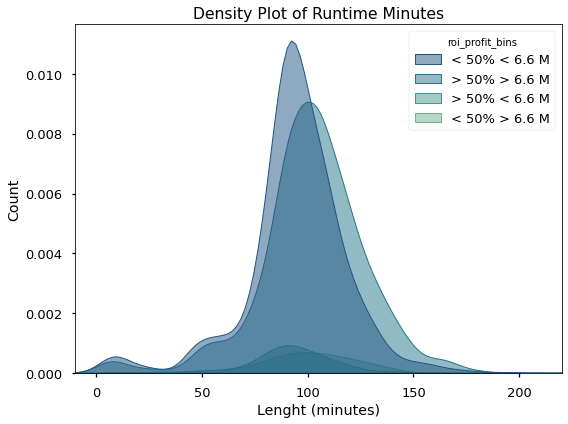

In [124]:
# A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analagous to a histogram. KDE represents the data using a continuous probability density curve in one or more dimensions.
# https://seaborn.pydata.org/generated/seaborn.kdeplot.html

with plt.style.context('seaborn-talk'):
    fig, ax1  = plt.subplots(figsize=(8, 6))
    sns.kdeplot(data = df_length , x = 'runtime_minutes', hue= 'roi_profit_bins', ax=ax1,\
               fill=True, alpha=.5, palette="crest_r", linewidth=1)
    ax1.set_title('Density Plot of Runtime Minutes')
    ax1.set_xlabel("Lenght (minutes)")
    ax1.set_ylabel("Count")
    ax1.set_xlim(-10,220)
    
    fig.tight_layout();
    fig.savefig('./images/kdeplot_RuntimeMinutes.png', dpi=300);

In [125]:
df_length.groupby('roi_profit_bins')['runtime_minutes'].mean() 

roi_profit_bins
< 50% < 6.6 M     94.682875
< 50% > 6.6 M     99.703125
> 50% < 6.6 M     91.801587
> 50% > 6.6 M    102.435237
Name: runtime_minutes, dtype: float64

- There is not a strong effect of runtime minutes. 
- But higher roi and higher profit movies tend to be slightly longer compared to low roi - low profit movies on average. 
- On average a movie in the high roi - high profit bin is **102 minutes** (approximately, 1 hour 40 minutes) long. 

- Let's convert `runtime_minutes` into a categorical variable by binning it. 
- Let's limit it at 200 minutes to avoid outliers. 

In [126]:
df_length['runtime_bins'] = pd.cut(df_length['runtime_minutes'],\
                                   bins=list(range(0, 220, 20)),\
                                   labels=['0-20','20-40','40-60','60-80','80-100',\
                                           '100-120','120-140','140-160','160-180','180-200'])


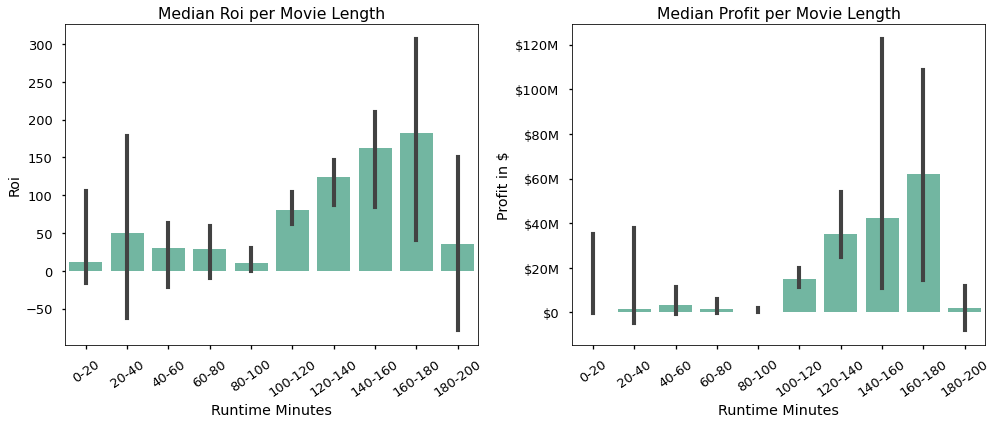

In [127]:
with plt.style.context('seaborn-talk'):
    fig,(ax1, ax2) = plt.subplots(figsize=(14,6), ncols=2)
    base_color = sns.color_palette("Set2")[0]
    sns.barplot(data=df_length, x='runtime_bins', y='roi', estimator = np.median, ci=95, color = base_color, ax=ax1)
    sns.barplot(data=df_length, x='runtime_bins', y='profit', estimator = np.median, ci=95, color = base_color, ax=ax2)
   
    ax2.yaxis.set_major_formatter(formatter)

    ax1.set_xticklabels(ax1.get_xticklabels(),rotation=35)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=35)
    
    
    ax1.set_title('Median Roi per Movie Length')
    ax2.set_title('Median Profit per Movie Length')
    
    ax1.set_xlabel('Runtime Minutes')
    ax2.set_xlabel('Runtime Minutes')
    
    ax1.set_ylabel('Roi') 
    ax2.set_ylabel('Profit in $')
    
    fig.tight_layout();
    fig.savefig('./images/Barplot_RuntimeMinutes.png', dpi=300);
    
# The 95% confidence interval is a range of values that you can be 95% confident contains the true mean of the population. 

- If you focus on profit the least risky lenght interval which would maximaxize profit is **120-140 min**. 
- 140-180 has the potential to bring more profit but it also has the risks of bringing less profit.  

- If you focus on roi the least risky lenght interval which would maximaxize roi is **120-160 min**. 
- 160-180 has the potential to bring more roi but it also has the risks of bringing less roi.

OVERALL: For the most profit and ROI, target **120-140 min** movie lenght. This is a little over 2 hours. 

## Evaluation

There are many reasons why a specific movie becomes successful and there is not one specific recipe. Here I focused on Return on Investment and Profit as means to assess movie profitability. 


## Conclusions
Based on my exploratory analyses I am able to make these specific proposals:

***

#### Which genre is most profitable?:
- For low budgeted movies focus on:
    - **HORROR**
    - **MYSTERY** which can bring a high Return on Invesment.
- For higher budgeted movies focus on:
    - **ANIMATION** 
    - **ADVENTURE**
    - **SCI_FI** which can bring a high cash value (profit).

#### Which directors are most profitable?:
- With smaller budget where you care more about the return on investment you should hire:
    - **Chris Lofing**
    - **Travis Cluff**
    - **Sébastien Lifshitz**
    - **Sujit Mondal**
    - **Adnan A. Shaikh**

- With large budget where you care more about the cash value it would return you should hire:
    - **Atsushi Wada**
    - **Kevin Lincoln**
    - **Ravi Punj**
    - **Pete Meads**

#### Which months are the best to release a movie?:
- Best month to release is: **NOVEMBER**: High returns on investment as well as profit occur mostly in the month of November probably due to the start of holiday season and cooler weather in the northern countries.
- If November window is missed then wait intil **January** to release. Do NOT release in December. 
- **June and July** are also next best options to release. 

#### Which movie length should be targeted? 
-  For the most profit and ROI, target **120-140 min** movie lenght. This is a little over 2 hours. 




## Limitations

- Sample size was reduced due to lack of budget and gross information on many movies. API calls or wed sraping would be good strategies to expand the data size.  
- Movie names were not coded the same way in different datasets which made the merging process challenging and insufficient. 
- Since many movies belong to several genres, the same movie has been used repeatedly for some of genre categories.
- The precense of strong outliers with very high ROI or very low Budgets made the analyses more challenging.

***